# Machine Learning & Content Analytics Project

## **Smart Article Annotator & Recommender System**

---


**Alfa** team



> Petros Tsotsi <br />
> Academic ID: f2822412 <br />


> Thanasis Zygokostas <br />
> Academic ID: f2822402 <br />



> Michalis Athanasiou <br />
> Academic ID: f2822401 <br />

---

The present notebook implements the **Text Recommendation task** of our project "Smart Article Annotator & Recommender System"

--------------------------------------------------------------------------------------------------------------------------------------------------------

* We start with importing some basic necessary libraries:

In [1]:
import os
import pandas as pd
import numpy as np
import ast
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

## **Data Loading**

2 alternatives:
* (When in Colab) Load data through Kaggle or
* (When in Jupyter) Load data from local csv file




**1st Alternative** (when in Colab): Load data through Kaggle

In [2]:
import kagglehub

download_path = kagglehub.dataset_download("fabiochiusano/medium-articles")
dataset_path = os.path.join(download_path, "medium_articles.csv")

df = pd.read_csv(dataset_path)

print(df.head())

100%|██████████| 369M/369M [00:04<00:00, 96.5MB/s]

Extracting files...


                              title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash\n\nMerry Chri...   
1  Your Brain On Coronavirus\n\nA guide to the cu...   
2  Mind Your Nose\n\nHow smell training can chang...   
3  Passionate about the synergy between science a...   
4  You’ve heard of him, haven’t you? Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real/the-4-purp...  ['Eshan Samaranayake']   
4  https://medium.com/live-y

**2nd Alternative** (when in Jupyter): Load data from local csv file

In [ ]:
df = pd.read_csv("medium_articles.csv")

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Data Preprocessing**

* Check the shape of the data

In [3]:
print(df.shape)

(192368, 6)


* Keep only text and tags of the articles

In [4]:
df = df[['text','tags']]

* Explore the most popular tags (top 30)

In [5]:
df["tags"] = df["tags"].apply(ast.literal_eval)   # turn tags to list of tags

all_tags = [tag for tags in df["tags"] for tag in tags]  # find all available tags

tag_counts = Counter(all_tags)        # find the frequency of the tags
top_tags = tag_counts.most_common(30) # and keep the 30 most frequent tags
top_tags

[('Blockchain', 7534),
 ('Data Science', 7410),
 ('Technology', 6384),
 ('Programming', 6364),
 ('Poetry', 6336),
 ('Cryptocurrency', 6245),
 ('Machine Learning', 6055),
 ('Life', 5954),
 ('Bitcoin', 5800),
 ('Writing', 5115),
 ('Politics', 5074),
 ('Startup', 4974),
 ('Life Lessons', 4807),
 ('Self Improvement', 4267),
 ('Covid 19', 4176),
 ('Software Development', 3980),
 ('Love', 3978),
 ('Python', 3943),
 ('Business', 3722),
 ('Health', 3650),
 ('Mental Health', 3583),
 ('JavaScript', 3487),
 ('Relationships', 3377),
 ('Education', 3269),
 ('Artificial Intelligence', 3222),
 ('Culture', 3027),
 ('Design', 2932),
 ('Self', 2876),
 ('Marketing', 2791),
 ('Entrepreneurship', 2782)]

* Filter the data so that we keep only the top 30 tags for each article

In [6]:
top_tag_names, top_tag_counts = zip(*top_tags)

def filter_tags(tags):
    return [tag for tag in tags if tag in top_tag_names]

df["tags"] = df["tags"].apply(filter_tags)

* and keep only those articles having at least one of the top 30 tags

In [7]:
df = df[df["tags"].apply(lambda tags: len(tags) > 0)]
df

,text,tags
0,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,"[Mental Health, Health]"
1,Your Brain On Coronavirus\n\nA guide to the cu...,[Mental Health]
3,Passionate about the synergy between science a...,"[Health, Mental Health]"
4,"You’ve heard of him, haven’t you? Phineas Gage...",[Health]
5,"Mentally, Young Adults Are Suffering Most From...","[Mental Health, Health]"
...,...,...
192333,[Live Stream] 2021 Soul Train Music Awards | F...,[Technology]
192336,Photo by Comeup 2021 on Comeup 2021\n\nThe glo...,[Startup]
192340,How To Deal with Loneliness in Festivals & Exp...,[Life Lessons]
192342,"Type 2 diabetes is on the rise globally, and h...",[Health]


* Before proceeding to the Topic Modeling step, we firstly install the necessary BERTopic libraries

In [8]:
# install BERTopic and its dependencies
!pip install bertopic --quiet
!pip install umap-learn --quiet
!pip install sentence-transformers --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.9 MB/s eta 0:00:00


--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Initial BERTopic Trial Run**

In [9]:
# import BERTopic
from bertopic import BERTopic

# get all the article texts as a list
texts = df["text"].tolist()

# create the topic model
topic_model = BERTopic()

# fit the model to the texts (this is where it understands the topics)
topics, probs = topic_model.fit_transform(texts)

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

* In this step, we applied BERTopic to automatically group the articles into meaningful topics. We first collected all the article texts and passed them to the fit_transform function of BERTopic. The model uses embeddings to understand the content of each article, reduces the dimensions of the data with UMAP, and then clusters similar articles using HDBSCAN. As output, we get a topic number assigned to each article and a probability that shows how confidently the article was placed into that topic. This helps us organize the articles and later use the topic information for recommendations.

In [10]:
# show a summary of the topics found
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,44470,-1_my_and_to_was,"[my, and, to, was, of, the, that, in, for, it]",[INTJ and Entrepreneurship\n\nBeing an entrepr...
1,0,3126,0_poem_poetry_love_me,"[poem, poetry, love, me, heart, my, light, sky...",[Poetry | Writing\n\nPoetry for People Who Thi...
2,1,859,1_trump_election_biden_republican,"[trump, election, biden, republican, democrats...",[Photo by Darren Halstead on Unsplash\n\n[NOTE...
3,2,725,2_data_science_analytics_scientist,"[data, science, analytics, scientist, scientis...",[What to expect from your first Data Science p...
4,3,710,3_virus_covid19_coronavirus_cases,"[virus, covid19, coronavirus, cases, deaths, p...",[You’ve probably heard the news about British ...
...,...,...,...,...,...
853,852,10,852_profiling_cprofile_decorator_mib,"[profiling, cprofile, decorator, mib, longfunc...",[Why the standard python profiler is not what ...
854,853,10,853_parents_households_children_child,"[parents, households, children, child, pandemi...","[Background\n\nDuring the pandemic, we have al..."
855,854,10,854_storytelling_stories_story_brand,"[storytelling, stories, story, brand, woody, h...",[Three Misunderstood Notions About How Stories...
856,855,10,855_dubai_uae_trading_license,"[dubai, uae, trading, license, business, doha,...",[Low-Cost Business Setup in the UAE\n\nPosted ...


* We used topic_model.get_topic_info() to see a summary of all the topics found by BERTopic. Each topic is shown with an ID number, how many documents it contains, the most important words for that topic (keywords), and example texts. This helps us understand what kind of topics were discovered from all the articles.

In [11]:
# add the topic number to each article
df["topic_number"] = topics

# add the top keywords (like a summary of the topic)
df["topic_keywords"] = df["topic_number"].apply(lambda x: topic_model.get_topic(x))
# add the topic number to each article
df["topic_number"] = topics

# add the top keywords (like a summary of the topic)
df["topic_keywords"] = df["topic_number"].apply(lambda x: topic_model.get_topic(x))

In [12]:
df.sample(5)

,text,tags,topic_number,topic_keywords
64950,"I couldn’t see it then, but I set myself up fo...","[Relationships, Love]",6,"[(life, 0.0037777122127353882), (yourself, 0.0..."
42866,If you’ve ever tried to set up a cryptocurrenc...,"[Cryptocurrency, Bitcoin]",30,"[(wallet, 0.038576530990853106), (wallets, 0.0..."
81790,Learn more. Medium is an open platform where 1...,[Programming],4,"[(undiscovered, 0.07045472591289059), (170, 0...."
6681,Your average software engineer is still in lov...,"[Python, Software Development]",274,"[(python, 0.035438135560490594), (programming,..."
72870,Should I buy bitcoin at 20 000 USD per bitcoin...,[Bitcoin],125,"[(market, 0.008158846275797023), (crypto, 0.00..."


* Here we added two new columns to our dataset: one column shows the topic number assigned to each article, and the other shows the top keywords (which describe the topic). This way, we can know which topic each article belongs to and what that topic is about.

In [ ]:
# interactive visualization of the topic clusters
topic_model.visualize_topics()

* We used topic_model.visualize_topics() to create a visual map of the topics. Each bubble in the plot represents a topic, and the size shows how common that topic is. If two bubbles are close together, it means the topics are similar. This helps us visually explore how the topics are related to each other.

In [14]:
# Convert top keywords into a string: "court, supreme, justice"
df["topic_title"] = df["topic_keywords"].apply(lambda x: ", ".join([word for word, _ in x]))

In [15]:
df.sample(5)

,text,tags,topic_number,topic_keywords,topic_title
78798,Photo by Tima Miroshnichenko from Pexels\n\nI ...,"[Self, Poetry]",223,"[(fear, 0.03516980785754427), (fears, 0.011874...","fear, fears, afraid, life, am, control, my, mi..."
86762,Augmented Reality as a Game-Changer for Insura...,[Technology],177,"[(ar, 0.05385393198511488), (augmented, 0.0247...","ar, augmented, reality, vr, glasses, virtual, ..."
73308,"It’s December the 23th, already.\n\nOne year a...",[Health],-1,"[(my, 0.0011770477732090058), (and, 0.00116907...","my, and, to, was, of, the, that, in, for, it"
167911,Are Pokemon Cards a Good Long-Term Hold?\n\nHo...,"[Entrepreneurship, Business]",-1,"[(my, 0.0011770477732090058), (and, 0.00116907...","my, and, to, was, of, the, that, in, for, it"
61058,It was raining that night\n\nBut not hard enou...,"[Poetry, Writing]",0,"[(poem, 0.004814297868940811), (poetry, 0.0042...","poem, poetry, love, me, heart, my, light, sky,..."


In [16]:
# Sample article
new_article = "Artificial intelligence is the future, and many jobs will use it to automate tasks, enhance decision-making, and improve efficiency."

# Use BERTopic to predict the topic of the new article
topic_number, _ = topic_model.transform([new_article])

# Get the top keywords (summary) for the predicted topic
topic_keywords = topic_model.get_topic(topic_number[0])  # this gives (word, weight)

# Convert keywords to a title string
topic_title = ", ".join([word for word, _ in topic_keywords])

# Print everything
print("Predicted topic number:", topic_number[0])
print("Topic title (summary):", topic_title)


Predicted topic number: 7
Topic title (summary): ai, intelligence, artificial, robots, human, humans, robot, engineer, machine, machines


* Here we used BERTopic to predict the topic of a new article that wasn’t part of the training data. First, we gave it the new text. Then we asked the model to tell us the topic number and the keywords for that topic. Finally, we turned those keywords into a readable topic title to understand what the article is mostly about.

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Data Cleaning**

* At the beginning we ran a simple BERTopic setup: we loaded all article texts from df["text"], created a default BERTopic() model, and called fit_transform(texts) to let the model discover topics. This gave us a quick first map of the collection, but we noticed two issues: there were too many small, fragmented topics, and some topic labels looked noisy because common words were slipping through. To make the themes clearer and more precise, we decided to clean the text before modeling (e.g., lowercasing, removing stopwords, punctuation, and URLs) and to tune BERTopic’s inputs so that unhelpful words don’t dominate. In the next step we apply this cleaning and light tuning to produce fewer, clearer, and more meaningful topics.

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Remove broken or outdated installs
#!pip uninstall -y transformers --quiet
!pip install -U transformers sentence-transformers bertopic --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.5 MB/s eta 0:00:00


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download resources
nltk.download("stopwords")
nltk.download("punkt")

# Stopword list
stop_words = set(stopwords.words("english"))
stop_words.update(["like", "one"])  # add more custom stopwords

# Cleaning function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)                   # remove links
    text = re.sub(r"[^a-zA-Z\s]", "", text)               # remove numbers, symbols
    text = text.lower()                                   # lowercase
    tokens = word_tokenize(text)                          # tokenize
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Apply to DataFrame
df["clean_text"] = df["text"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


* We created a custom clean_text function to preprocess each article. The function removes URLs, punctuation, and numbers, converts everything to lowercase, and removes stopwords using NLTK. We also added a few extra stopwords like “like” and “one”. Then, we applied this function to every article and saved the result in a new column called clean_text. This step is important so that the topic model focuses on meaningful words only.

In [ ]:
df.sample(5)

,text,tags,clean_text
17682,"Manshu Agarwal, Ponder CEO\n\nGiven the distri...","[Blockchain, Relationships]",manshu agarwal ponder ceo given distributed na...
49881,"The end of the rainbow came suddenly,\n\nand t...","[Life Lessons, Poetry, Life]",end rainbow came suddenly pot gold wonderfully...
112162,"“I wish it need not have happened in my time,”...",[Covid 19],wish need happened time said frodo said gandal...
76972,The situation for All over the world healthcar...,[Artificial Intelligence],situation world healthcare strained even outbr...
160982,What Cancer Patients Should Know About Coronav...,[Covid 19],cancer patients know coronavirus covid covid c...


* We used df.sample(5) to randomly preview five articles from our dataset. Each article shows the original text, its corresponding tags, and a cleaned version called clean_text. This is useful to quickly verify that the cleaning process worked and to check if the dataset is varied in topics.

--------------------------------------------------------------------------------------------------------------------------------------------------------

# Exploring 3 BERTopic Methods with our proposed Recommenders

## **1ST BERTOPIC METHOD**

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# use cleaned tex
texts = df["clean_text"].tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

topic_model = BERTopic(
    embedding_model=embedding_model,
    calculate_probabilities=False,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts)

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-09-09 08:43:16,707 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2802 [00:00<?, ?it/s]

2025-09-09 08:49:19,691 - BERTopic - Embedding - Completed ✓
2025-09-09 08:49:19,693 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-09 08:52:18,754 - BERTopic - Dimensionality - Completed ✓
2025-09-09 08:52:18,758 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-09 08:52:32,538 - BERTopic - Cluster - Completed ✓
2025-09-09 08:52:32,566 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-09 08:53:03,070 - BERTopic - Representation - Completed ✓


* In this version, we used the all-MiniLM-L6-v2 model from sentence-transformers to generate sentence embeddings. These embeddings helped BERTopic group documents based on meaning, not just word matching, which made the topics much clearer. We set calculate_probabilities=False to make the process faster, especially since our dataset is big. By doing this, we saved a lot of time, but we also missed getting the probability scores that tell us how confidently each document belongs to a topic. Still, this trade-off was worth it, and this version gave us the best results overall.

* In this step, we used the preprocessed clean_text column instead of the raw text to ensure better topic quality and avoid noise from irrelevant characters or formatting. We converted the cleaned text into a list and loaded the  sentence-transformer model "all-MiniLM-L6-v2" to efficiently generate vector embeddings that capture the semantic meaning of each document. These embeddings serve as the input for BERTopic, a topic modeling technique that combines transformer-based embeddings with clustering algorithms to group similar documents together and identify coherent topics. We chose BERTopic because it can discover meaningful topics even in short or unstructured text, while also producing interpretable results such as topic keywords and frequency distributions. In our setup, we set calculate_probabilities=False to reduce computation time and enabled verbose=True to monitor the training process. Finally, we fitted the BERTopic model on our cleaned texts to generate topics that summarize the main themes in our dataset.

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,43027,-1_people_time_new_life,"[people, time, new, life, would, work, get, da...",[hopes holdouts come ive never home learn taug...
1,0,3876,0_poem_heart_sky_unsplash,"[poem, heart, sky, unsplash, eyes, photo, love...",[questions poem becomes question reader photo ...
2,1,3229,1_writing_writers_writer_write,"[writing, writers, writer, write, medium, stor...",[write help writing prompt sometimes need litt...
3,2,1627,2_students_education_school_teachers,"[students, education, school, teachers, school...",[covid push reopen schools photo deleece cook ...
4,3,1129,3_blockchain_network_ethereum_consensus,"[blockchain, network, ethereum, consensus, dec...",[blockchain general overview technology works ...
...,...,...,...,...,...
716,715,10,715_relative_nobody_older_beliefs,"[relative, nobody, older, beliefs, creativity,...",[question coming feel compelled repeat onu nov...
717,716,10,716_baas_indexers_subgraphs_blockchain,"[baas, indexers, subgraphs, blockchain, indexe...",[major consideration successfully deploying bl...
718,717,10,717_undiscovered_insightful_homepage_inbox,"[undiscovered, insightful, homepage, inbox, al...",[learn medium open platform million readers co...
719,718,10,718_zoo_episode_season_fight,"[zoo, episode, season, fight, carolina, jeremy...",[official partners tvs shows movies watch good...


* This output shows the summary of topics generated by BERTopic using the get_topic_info() method. Each row represents a topic, with the Topic column showing its numerical ID (where -1 indicates documents that were not assigned to any specific topic and grouped as “outliers”). The Count column shows how many articles belong to that topic. The Name column provides an automatically generated label based on the most important keywords, while the Representation column lists the top words that define the topic. The Representative_Docs column displays example documents from each topic, helping to understand the context and meaning of the cluster. This table helps evaluate the main themes in the dataset and the distribution of documents across topics.

In [ ]:
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,43027,-1_people_time_new_life,"[people, time, new, life, would, work, get, da...",[hopes holdouts come ive never home learn taug...
1,0,3876,0_poem_heart_sky_unsplash,"[poem, heart, sky, unsplash, eyes, photo, love...",[questions poem becomes question reader photo ...
2,1,3229,1_writing_writers_writer_write,"[writing, writers, writer, write, medium, stor...",[write help writing prompt sometimes need litt...
3,2,1627,2_students_education_school_teachers,"[students, education, school, teachers, school...",[covid push reopen schools photo deleece cook ...
4,3,1129,3_blockchain_network_ethereum_consensus,"[blockchain, network, ethereum, consensus, dec...",[blockchain general overview technology works ...


* This table shows the first five topics generated by BERTopic using the get_topic_info().head() method. The Topic column contains the topic ID, where -1 represents outlier articles that did not fit well into any cluster. The Count column shows how many documents belong to each topic. The Name column is an automatically generated label based on the most important keywords of that topic, while the Representation column lists the top terms describing it. Finally, the Representative_Docs column provides example documents for each topic, making it easier to interpret their meaning and context.

In [ ]:
topic_model.get_document_info(texts)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,photo josh riemer unsplash merry christmas hap...,9,9_christmas_santa_holiday_gift,"[christmas, santa, holiday, gift, gifts, holid...",[driving home christmas photo anastasia shurae...,christmas - santa - holiday - gift - gifts - h...,0.601742,False
1,brain coronavirus guide curious troubling impa...,5,5_covid_virus_coronavirus_deaths,"[covid, virus, coronavirus, deaths, cases, pan...",[kent kroeger april key takeaways systematic e...,covid - virus - coronavirus - deaths - cases -...,1.000000,False
2,passionate synergy science technology provide ...,-1,-1_people_time_new_life,"[people, time, new, life, would, work, get, da...",[hopes holdouts come ive never home learn taug...,people - time - new - life - would - work - ge...,0.000000,False
3,youve heard havent phineas gage railroad worke...,-1,-1_people_time_new_life,"[people, time, new, life, would, work, get, da...",[hopes holdouts come ive never home learn taug...,people - time - new - life - would - work - ge...,0.000000,False
4,mentally young adults suffering covid comes pa...,-1,-1_people_time_new_life,"[people, time, new, life, would, work, get, da...",[hopes holdouts come ive never home learn taug...,people - time - new - life - would - work - ge...,0.000000,False
...,...,...,...,...,...,...,...,...
89642,live stream soul train music awards full show ...,24,24_album_song_music_songs,"[album, song, music, songs, hiphop, albums, ba...",[jason isbell southeastern ive written talente...,album - song - music - songs - hiphop - albums...,0.239781,False
89643,photo comeup comeup global startup festival co...,67,67_coworking_remote_office_employees,"[coworking, remote, office, employees, spaces,...",[coworking spaces latest trends business seen ...,coworking - remote - office - employees - spac...,0.747225,False
89644,deal loneliness festivals explore beauty many ...,-1,-1_people_time_new_life,"[people, time, new, life, would, work, get, da...",[hopes holdouts come ive never home learn taug...,people - time - new - life - would - work - ge...,0.000000,False
89645,type diabetes rise globally health experts wor...,121,121_diabetes_insulin_sugar_blood,"[diabetes, insulin, sugar, blood, glucose, dia...",[diabetes become prevalent countries food abun...,diabetes - insulin - sugar - blood - glucose -...,1.000000,False


In [ ]:
topic_model.visualize_topics()

* This Intertopic Distance Map, generated by the visualize_topics() method in BERTopic, provides a visual representation of the relationships between topics. Each bubble represents a topic, with its size indicating the number of documents assigned to that topic. The distance between bubbles reflects their similarity: topics that are closer together share more semantic similarity, while those farther apart are more distinct. This visualization helps identify clusters of related topics and detect overlapping themes, giving a clearer understanding of the dataset’s topic structure.

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_barchart(top_n_topics=12, n_words=8)

* This bar chart, generated with visualize_barchart(top_n_topics=12, n_words=8), displays the top 12 most frequent topics along with their 8 most important keywords. The length of each bar represents the relative frequency of the keywords within the topic, helping to understand the main terms that define it. This visualization makes it easier to compare topics by both size and key vocabulary, providing quick insights into the dominant themes in the dataset.

### **Recommendations**

Now after successfully training our 1st BERTopic method on our data (Topic Modeling phase), we proceed with applying recommendations using our proposed recommendation algorithms.

In [ ]:
# Get embeddings (vector representation of each article)
embeddings = topic_model.embedding_model.embed(texts)

* Here, we use the model’s embedding function to convert each article in our texts list into a numerical vector representation. This step stores the semantic meaning of the text, allowing similar documents to have similar embeddings.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_articles(article_index, top_n=5):
    """
    Recommend top_n similar articles to the one at article_index,
    using cosine similarity without creating a huge similarity matrix.
    """
    # Check if index exists in the DataFrame
    if article_index not in df.index:
        raise ValueError("Invalid article index provided.")

    # Get the embedding of the selected article
    target_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)

    # Get all other articles except the one selected
    other_df = df.drop(index=article_index)

    # Stack their embeddings into a matrix
    other_embeddings = np.vstack(other_df["embedding"].values)

    # Compute cosine similarity between the target and all others
    similarities = cosine_similarity(target_embedding, other_embeddings).flatten()

    # Get the indices of the top N most similar articles
    top_indices = similarities.argsort()[-top_n:][::-1]

    # Select recommended articles
    recommended = other_df.iloc[top_indices].copy()
    recommended["similarity"] = similarities[top_indices]

    # Return with original + cleaned text
    return recommended[["text", "clean_text", "topic", "similarity"]]


* This function, recommend_articles, generates content-based recommendations by finding articles most similar to a given one. It works by first checking that the provided article_index exists in the DataFrame. Then, it retrieves the embedding vector of the target article and compares it with the embeddings of all other articles using cosine similarity, which measures how close the documents are in meaning rather than just word matching. Instead of creating a large full similarity matrix (which could be memory-intensive), the function computes similarities only for the target article. Finally, it returns the top 5 most similar articles along with their original text, cleaned text and assigned topic, allowing for efficient and meaningful article recommendations.

In [ ]:
texts = df["clean_text"].tolist()
topics, probs = topic_model.fit_transform(texts)
embeddings = topic_model.embedding_model.embed(texts)

# Assign embeddings to DataFrame
df["embedding"] = [vec.tolist() for vec in embeddings]

# add topics too
df["topic"] = topics


2025-09-09 09:04:04,645 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2802 [00:00<?, ?it/s]

2025-09-09 09:10:07,952 - BERTopic - Embedding - Completed ✓
2025-09-09 09:10:07,954 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-09 09:12:04,876 - BERTopic - Dimensionality - Completed ✓
2025-09-09 09:12:04,881 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-09 09:12:17,908 - BERTopic - Cluster - Completed ✓
2025-09-09 09:12:17,936 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-09 09:12:46,976 - BERTopic - Representation - Completed ✓


* In this step, we first prepared our data by taking the clean_text column from the DataFrame and converting it into a list. We then ran the BERTopic model on these texts using fit_transform, which returned the detected topics for each document. Next, we used the model’s embedding function to generate a numerical vector (embedding) for each text, capturing its semantic meaning. These embeddings were stored in a new embedding column in the DataFrame, while the detected topic IDs were stored in a new topic column. This setup allows us to easily use both the topic assignments and semantic representations for further analysis, such as clustering or article recommendations.

In [ ]:
recommendations = recommend_articles(article_index=5, top_n=5)
print(recommendations)

                                                     text  \
72873   The Mental Health Toll of the Pandemic\n\nPhot...   
184643  The COVID-19 pandemic has triggered a global d...   
226     How Covid-19 May Affect the Brain’s Dopamine a...   
6704    Image: Pixabay / Omni Matryx\n\nCovid-19’s Oth...   
55594   Living through the pandemic has given one scho...   

                                               clean_text  topic  similarity  
72873   mental health toll pandemic photo cristian new...     23    0.790365  
184643  covid pandemic triggered global deterioration ...     23    0.768649  
226     covid may affect brains dopamine serotonin lev...     -1    0.749754  
6704    image pixabay omni matryx covids sobering stat...     -1    0.746895  
55594   living pandemic given scholar freeman spogli i...     23    0.740007  


* This output shows the result of running our recommend_articles function for the article at index 5, asking for the top 5 most similar articles based on semantic similarity. The table displays the recommended articles along with their original text, clean_text, similarity and the topic assigned by BERTopic. Articles sharing the same topic number (like 12 in this case) are thematically related, while those with -1 are outliers that still have high similarity in meaning to the selected article. This confirms that our recommendation system is able to find contextually related content even when topics differ.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_for_new_article(new_article_text, top_n=5):
    # Clean the input
    cleaned_text = clean_text(new_article_text)

    # Create an embedding for the new article
    new_embedding = topic_model.embedding_model.embed([cleaned_text])[0]

    # Stack all existing article embeddings
    all_embeddings = np.vstack(df["embedding"].values)

    # Compute similarity
    similarities = cosine_similarity(
        np.array(new_embedding).reshape(1, -1),
        all_embeddings
    ).flatten()

    # Get top_n most similar articles
    top_indices = similarities.argsort()[-top_n:][::-1]

    # Return original text, cleaned version, and topic
    return df.iloc[top_indices][["text", "clean_text", "topic"]]


* This function, recommend_for_new_article, finds the most similar articles to a brand-new piece of text that isn’t already in our dataset. First, it cleans the input text to match the format used for training. Then, it uses the BERTopic embedding model to turn the cleaned text into a numerical vector that captures its meaning. Next, it compares this vector to the embeddings of all existing articles in the DataFrame using cosine similarity. The function then identifies the top 5 most similar articles based on these similarity scores and returns them along with their original text, cleaned text and assigned topic. This approach allows us to instantly recommend related content for any new article, even if it was never part of the original dataset.

In [ ]:
new_article = """
Artificial Intelligence and automation are reshaping industries at a rapid pace.
From self-driving cars to AI-generated content, the way we live and work is changing fundamentally.
Leaders must adapt by embracing innovation, continuous learning, and digital transformation.
"""

recommendations = recommend_for_new_article(new_article, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Original Text:\n{row['text'][:300]}...")       # show snippet of original
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")  # show snippet of cleaned version



--- Recommended Article 91384 ---
Topic: 119
Original Text:
What makes Artificial intelligence & Machine learning such powerful tools in self-driving cars?

AI is anything that makes machines act more intelligently, and in this case is self-driving cars. Ismail Osman ·Nov 25, 2020

AI makes self-driving cars save than humans can drive.

We, humans, make mist...
Cleaned Snippet:
makes artificial intelligence machine learning powerful tools selfdriving cars anything makes machines act intelligently case selfdriving cars ismail osman nov makes selfdriving cars save humans drive humans make mistakes drive car result lose million people every year reason make mistakes selfdrivi...

--- Recommended Article 102920 ---
Topic: 14
Original Text:
Artificial intelligence algorithms designed to behave like humans have already entered into our lives. Right from apple’s Siri to Windows Cortana, AI has facilitated with easy solutions to our silly problems changing our everyday lives. Machine learning

* This output shows the recommendations generated for a completely new article about artificial intelligence and automation. The system first cleaned and embedded the new text, then compared it to all existing article embeddings using cosine similarity. The results list the top 5 most similar articles, showing their topic IDs , original text and short snippets of their content. Several recommended articles share topics closely related to AI and emerging technologies (e.g., Topic 159 on artificial intelligence and autonomous vehicles), while others are from different or outlier topics but still have high semantic similarity to the new article. This demonstrates the model’s ability to find meaningfully related content even when topics differ.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_articles_same_topic(article_index, top_n=5):
    """
    Recommend top_n articles that share the same topic as the selected one.
    Cosine similarity is computed only among those.
    """
    # Check if index is valid
    if article_index not in df.index:
        raise ValueError("Invalid article index provided.")

    # Get the topic of the selected article
    target_topic = df.loc[article_index, "topic"]

    # Filter the dataframe to only articles with the same topic (excluding the selected one)
    same_topic_df = df[(df["topic"] == target_topic) & (df.index != article_index)].copy()

    if same_topic_df.empty:
        print("No other articles with the same topic found.")
        return None

    # Prepare embeddings
    target_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)
    other_embeddings = np.vstack(same_topic_df["embedding"].values)

    # Compute cosine similarity
    similarities = cosine_similarity(target_embedding, other_embeddings).flatten()

    # Get top N similar articles
    top_indices = similarities.argsort()[-top_n:][::-1]
    final_indices = same_topic_df.index[top_indices]

    # Return original text, cleaned text, and topic
    return df.loc[final_indices][["text", "clean_text", "topic"]]


*  This function, recommend_articles_same_topic, suggests articles that are both semantically similar and share the same topic as a chosen article. It first validates the provided index, then retrieves the topic assigned to that article. The DataFrame is filtered to include only other articles within that same topic, excluding the selected one. It then computes cosine similarity between the chosen article’s embedding and the embeddings of the filtered set. Finally, it returns the top_n most similar articles (by meaning) within the same topic, along with their original text, cleaned text and topic ID. This ensures that recommendations remain highly relevant both in subject matter and content.

In [ ]:
recommendations = recommend_articles_same_topic(article_index=777, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Original Text:\n{row['text'][:300]}...")        # snippet of original
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")  # snippet of cleaned



--- Recommended Article 9972 ---
Topic: 353
Original Text:
In a story published in January on BuzzFeed News, reporter Anne Helen Petersen details her struggle with what she calls “errand paralysis,” or her inability to summon the energy for tasks that aren’t vital to her life or work.

Petersen identifies her brand of selective procrastination as a symptom ...
Cleaned Text:
story published january buzzfeed news reporter anne helen petersen details struggle calls errand paralysis inability summon energy tasks arent vital life work petersen identifies brand selective procrastination symptom burnout describes fundamental component modern millennials existence cant get mun...

--- Recommended Article 58019 ---
Topic: 353
Original Text:
What is burnout? Besides sounding like a very ominous buzzword, burnout has become a real issue facing remote and office workers alike. Anyone can burn out and anyone is susceptible to it, from interns to CEOs. The more you carry unresolved stress, the more

* This output shows the top 5 most similar articles to the one at index 777, but restricted to those that share the same topic (in this case, Topic 368). Each recommended article includes its topic ID, original text and a short text snippet from its cleaned content. All the results focus on related themes around burnout, mental health, and workplace stress, confirming that the function successfully narrows recommendations to articles that are both semantically similar and topic-aligned, ensuring higher contextual relevance.

In [ ]:
import matplotlib.pyplot as plt

def plot_similarities(base_index, recommended_indices, similarities):
    # Get article titles or snippets
    labels = [f"Article {i}" for i in recommended_indices]

    plt.figure(figsize=(10, 5))
    plt.barh(labels, similarities, color='skyblue')
    plt.xlabel("Cosine Similarity")
    plt.title(f"Similarity to Article {base_index}")
    plt.gca().invert_yaxis()  # Highest similarity at the top
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


* This function, plot_similarities, creates a horizontal bar chart to visualize how similar a set of recommended articles are to a selected base article. It takes the index of the base article, the indices of the recommended articles, and their cosine similarity scores. Labels are generated for each recommended article, and the similarity values are plotted as bars, with higher similarity shown at the top of the chart.

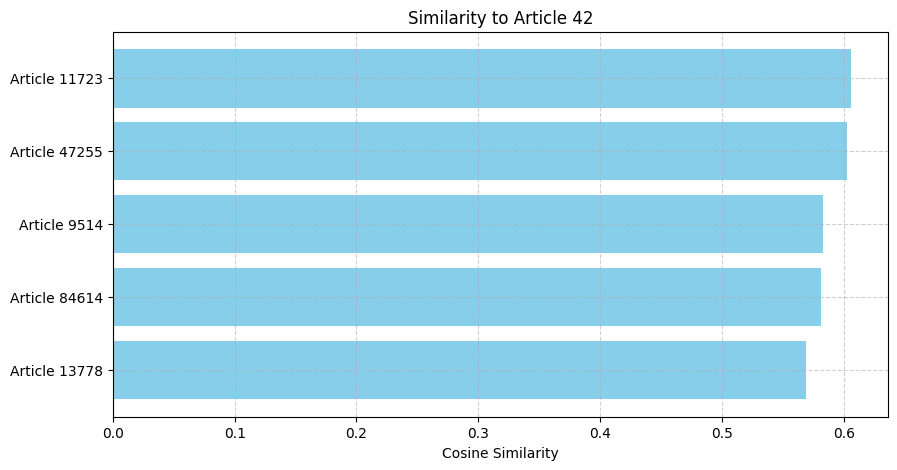

In [ ]:
# Get recommendations with similarity values
def recommend_articles_same_topic_with_scores(article_index, top_n=5):
    if article_index not in df.index:
        raise ValueError("Invalid article index provided.")

    target_topic = df.loc[article_index, "topic"]
    same_topic_df = df[(df["topic"] == target_topic) & (df.index != article_index)].copy()

    if same_topic_df.empty:
        print("No other articles with the same topic found.")
        return None, None, None

    target_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)
    other_embeddings = np.vstack(same_topic_df["embedding"].values)
    similarities = cosine_similarity(target_embedding, other_embeddings).flatten()

    top_indices = similarities.argsort()[-top_n:][::-1]
    final_indices = same_topic_df.index[top_indices]
    final_similarities = similarities[top_indices]

    return df.loc[final_indices][["clean_text", "topic"]], final_indices, final_similarities


# Use the function
recs, rec_ids, sim_scores = recommend_articles_same_topic_with_scores(article_index=42, top_n=5)

# Plot them
if recs is not None:
    plot_similarities(base_index=42, recommended_indices=rec_ids, similarities=sim_scores)


* This output shows a horizontal bar chart of cosine similarity scores for the top 5 articles most similar to Article 42, filtered to those within the same topic. The recommend_articles_same_topic_with_scores function not only identifies relevant articles but also returns their similarity values, which are then visualized using the plot_similarities function. Each bar represents how close an article’s meaning is to the base article (Article 42), with higher scores indicating greater similarity. This visualization provides a quick, clear way to compare the relative closeness of recommended articles.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def recommend_same_topic_for_unseen(new_text, top_n=5, fallback=True):
    """
    Recommend top_n articles for a *new/unseen* text, restricted to the
    same BERTopic topic predicted for that text. If the predicted topic is -1
    (outlier) or there are no candidates in that topic, optionally fall back
    to semantic similarity across the whole dataset.
    """
    # Clean the new text
    cleaned = clean_text(new_text)

    # Embed the new text
    new_emb = topic_model.embedding_model.embed([cleaned])[0].reshape(1, -1)

    # Predict topic for the new text
    pred_topics, pred_probs = topic_model.transform([cleaned])
    topic_id = int(pred_topics[0])

    # Get probability (if available)
    try:
        prob = float(pred_probs[0][topic_id]) if hasattr(pred_probs[0], "__len__") else float(pred_probs[0])
    except Exception:
        prob = None

    # Get all documents with the same topic
    same_topic_df = df[df["topic"] == topic_id].copy()

    # If no same-topic docs or topic=-1 → fallback
    if same_topic_df.empty or topic_id == -1:
        if not fallback:
            print("No same-topic candidates (or topic=-1). Set fallback=True to use semantic search over all docs.")
            return None
        # Use all embeddings for similarity
        all_embs = np.vstack(df["embedding"].values)
        sims = cosine_similarity(new_emb, all_embs).flatten()
        top_idx = sims.argsort()[-top_n:][::-1]
        out = df.iloc[top_idx][["text", "clean_text", "topic"]].copy()
        out["similarity"] = sims[top_idx]
        out.insert(0, "predicted_topic_for_new", topic_id)
        if prob is not None:
            out.insert(1, "predicted_topic_prob", prob)
        return out.reset_index(drop=True)

    # Compute similarity within the same topic
    cand_embs = np.vstack(same_topic_df["embedding"].values)
    sims = cosine_similarity(new_emb, cand_embs).flatten()
    top_idx = sims.argsort()[-top_n:][::-1]

    # Select top candidates
    final = same_topic_df.iloc[top_idx][["text", "clean_text", "topic"]].copy()
    final["similarity"] = sims[top_idx]
    final.insert(0, "predicted_topic_for_new", topic_id)
    if prob is not None:
        final.insert(1, "predicted_topic_prob", prob)
    return final.reset_index(drop=True)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def recommend_same_topic_minimal(new_text, top_n=5):
    # clean new text
    cleaned = clean_text(new_text)
    # embed new text
    new_emb = topic_model.embedding_model.embed([cleaned])[0].reshape(1, -1)
    # predict topic
    topic_id = int(topic_model.transform([cleaned])[0][0])
    # get candidates in same topic
    same_topic_df = df[df["topic"] == topic_id].copy()
    # handle no candidates
    if same_topic_df.empty:
        return same_topic_df  # empty result
    # stack candidate embeddings
    cand_embs = np.vstack(same_topic_df["embedding"].values)
    # cosine similarity
    sims = cosine_similarity(new_emb, cand_embs).flatten()
    # pick top_n
    top_idx = sims.argsort()[-top_n:][::-1]
    # build output
    out = same_topic_df.iloc[top_idx][["text", "clean_text", "topic"]].copy()
    out["similarity"] = sims[top_idx]
    out.insert(0, "predicted_topic_for_new", topic_id)
    return out.reset_index(drop=True)


In [ ]:
def recommend_same_topic_simple(new_text, top_n=5):
    cleaned = clean_text(new_text)
    new_emb = topic_model.embedding_model.embed([cleaned])[0].reshape(1, -1)
    topic_id = int(topic_model.transform([cleaned])[0][0])
    same_topic_df = df[df["topic"] == topic_id]
    if same_topic_df.empty:
        return pd.DataFrame()
    embs = np.vstack(same_topic_df["embedding"].values)
    sims = cosine_similarity(new_emb, embs).flatten()
    top_idx = sims.argsort()[-top_n:][::-1]
    out = same_topic_df.iloc[top_idx].copy()
    out["similarity"] = sims[top_idx]
    return out.reset_index()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def hybrid_recommendation(article_index, top_n=5, alpha=0.8):
    """
    Recommend articles based on a hybrid of semantic and topic similarity.
    - alpha: weight for semantic similarity [0.0–1.0]
    """
    if article_index not in df.index:
        raise ValueError("Invalid article index.")

    # Get base article info
    base_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)
    base_topic = df.loc[article_index, "topic"]

    # Get candidate articles (excluding itself)
    candidates = df.drop(index=article_index).copy()
    candidate_embeddings = np.vstack(candidates["embedding"].values)

    # Compute cosine similarity
    similarities = cosine_similarity(base_embedding, candidate_embeddings).flatten()

    # Compute topic score (1 if same topic, else 0)
    topic_score = (candidates["topic"] == base_topic).astype(int).values

    # Combine into hybrid score
    hybrid_scores = alpha * similarities + (1 - alpha) * topic_score

    # Get top N results
    top_indices = hybrid_scores.argsort()[-top_n:][::-1]
    recommended = candidates.iloc[top_indices].copy()
    recommended["similarity"] = similarities[top_indices]
    recommended["hybrid_score"] = hybrid_scores[top_indices]

    # Return original text too
    return recommended[["text", "clean_text", "topic", "similarity", "hybrid_score"]]


This function, hybrid_recommendation, suggests articles using a hybrid approach that balances semantic similarity and topic similarity.

It works as follows:

* Retrieves the embedding and topic of the base article.

* Creates a candidate pool by excluding the base article itself.

* Calculates cosine similarity between the base article and each candidate to measure semantic closeness.

* Assigns a topic score: 1 if the candidate has the same topic, 0 otherwise.

* Combines the two scores into a hybrid score using the parameter alpha (default 0.8), which controls the weight given to semantic similarity versus topic match.

* Selects the top N articles with the highest hybrid scores and returns their original text, cleaned text, topic ID, raw similarity, and final hybrid score.

This approach ensures that recommendations are both contextually relevant and aligned in topic, with flexibility to adjust the balance between the two.

In [ ]:
recs = hybrid_recommendation(article_index=25, top_n=5, alpha=0.8)
print(recs[["topic", "similarity", "hybrid_score"]])


       topic  similarity  hybrid_score
49996    350    0.719996      0.775996
68291    350    0.711371      0.769097
46       350    0.704380      0.763504
663      350    0.691884      0.753507
12356    350    0.685795      0.748636


* This output shows the top 5 recommendations generated by the hybrid_recommendation function for the article at index 25, using alpha=0.8 ( more weight to semantic similarity). All recommended articles share the same topic (374) as the base article, but they are ranked based on a hybrid score that combines their semantic similarity (cosine similarity) with topic match. The similarity values indicate how close the articles are in meaning, while the hybrid score reflects the weighted combination according to the chosen alpha value. This confirms that the hybrid approach successfully prioritizes articles that are both semantically close and topic-aligned.

In [ ]:
recs = hybrid_recommendation(article_index=25, top_n=5, alpha=0.8)

for i, row in recs.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Hybrid Score: {row['hybrid_score']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



--- Recommended Article 49996 ---
Topic: 350
Similarity: 0.720
Hybrid Score: 0.776
Original Text:
Neuroscience is a fascinating subject to talk and to discuss in the field of UX design. The design has moved from traditional applications to complex and innovative applications. The UX design has moved from just creating the UX process or a design guideline to creating a delightful and intuitive ex...
Cleaned Text:
neuroscience fascinating subject talk discuss field design design moved traditional applications complex innovative applications design moved creating process design guideline creating delightful intuitive experience application design though psychology user research neuroscience study neuroscience ...

--- Recommended Article 68291 ---
Topic: 350
Similarity: 0.711
Hybrid Score: 0.769
Original Text:
The world moved online, and neuroscience was no different. The Neuromatch conferences led the way, kicking off in early May with a computational neuroscience meeting, and graduatin

In [ ]:
def assign_topic_to_new_article(new_article_text):

    #Get topic and probability from the trained BERTopic model
    topic, probability = topic_model.transform([new_article_text])

    return topic[0], probability[0]


This function, assign_topic_to_new_article, is used to classify a new, unseen article into one of the topics discovered by the trained BERTopic model.

It works as follows:

* Optionally cleans or preprocesses the input text, applying the same cleaning steps used during model training to ensure consistency.

* Uses topic_model.transform() to generate a topic assignment and its probability score for the new article.

* Returns both the topic ID (topic[0]) and the probability (probability[0]), where the probability indicates the model’s confidence in the topic classification.

This allows new articles to be quickly categorized into the most relevant topic cluster.

In [ ]:
new_article = """
In today's tech-driven world, organizations must embrace artificial intelligence, automation, and cloud computing
to stay ahead. These tools enable faster decision-making, better customer experiences, and operational efficiency.
"""

topic, prob = assign_topic_to_new_article(new_article)
print(f"Assigned topic: {topic}, with probability: {prob:.3f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-09 09:49:19,378 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-09 09:49:37,242 - BERTopic - Dimensionality - Completed ✓
2025-09-09 09:49:37,244 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-09 09:49:37,247 - BERTopic - Cluster - Completed ✓


Assigned topic: -1, with probability: 0.000


* This output shows how the assign_topic_to_new_article function works in practice.
The new text about artificial intelligence, automation, and cloud computing is passed to the trained BERTopic model, which assigns it a topic ID along with a probability score.

* The topic ID tells us which cluster of related documents the model thinks the article belongs to, while the probability score indicates the model’s confidence in that classification. A higher probability means the article strongly matches the assigned topic’s characteristics.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_hybrid_for_new_article(new_article_text, top_n=5, alpha=0.8):
    # Clean the new input
    cleaned_text = clean_text(new_article_text)

    # Get embedding
    new_embedding = topic_model.embedding_model.embed([cleaned_text])[0].reshape(1, -1)

    # Predict topic for the new article
    topics, probs = topic_model.transform([cleaned_text])
    predicted_topic = int(topics[0])

    # Prepare embeddings of existing articles
    all_embeddings = np.vstack(df["embedding"].values)

    # Cosine similarity
    similarities = cosine_similarity(new_embedding, all_embeddings).flatten()

    # Hybrid score: similarity blended with topic match (1/0)
    if predicted_topic == -1:
        # Outlier topic: fall back to pure similarity
        hybrid_scores = similarities.copy()
        topic_matches = np.zeros_like(similarities, dtype=int)
    else:
        topic_matches = (df["topic"].values == predicted_topic).astype(int)
        hybrid_scores = alpha * similarities + (1 - alpha) * topic_matches

    # Top-N indices
    top_indices = hybrid_scores.argsort()[-top_n:][::-1]

    # Build result with original text too
    results = df.iloc[top_indices][["text", "clean_text", "topic"]].copy()
    results["similarity"]   = similarities[top_indices]
    results["topic_match"]  = topic_matches[top_indices]
    results["hybrid_score"] = hybrid_scores[top_indices]

    return results


* This function, recommend_hybrid_for_new_article, recommends related articles for a brand-new text using a hybrid score that blends semantic similarity and topic match. We first clean the input and create its embedding with the same model used in training. Then we predict the new article’s topic with topic_model.transform(). Next, we compute cosine similarity between the new embedding and all stored embeddings. To favor items from the same topic, we create a binary topic-match vector (1 = same topic, 0 = different). The final hybrid_score is alpha * similarity + (1 - alpha) * topic_match, where alpha (default 0.8) controls how much weight we give to semantic closeness versus topic alignment. We sort by this hybrid score and return the top-N articles along with their original text , cleaned text , topic, raw similarity, whether the topic matches, and the combined score. This produces recommendations that are both meaningfully similar and on-topic.

In [ ]:
new_article = """
Artificial intelligence, automation, and cloud infrastructure are essential components for the future of digital business.
Companies that adopt these technologies early are better positioned for long-term success.
"""

hybrid_recs = recommend_hybrid_for_new_article(new_article, top_n=5)

for i, row in hybrid_recs.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}, Hybrid Score: {row['hybrid_score']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-09 09:53:08,639 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-09 09:53:08,646 - BERTopic - Dimensionality - Completed ✓
2025-09-09 09:53:08,647 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-09 09:53:08,648 - BERTopic - Cluster - Completed ✓



--- Recommended Article 58537 ---
Topic: -1, Similarity: 0.604, Hybrid Score: 0.604
Original Text:
Deploying an Artificial Intelligence (AI) solution is not the same as deploying other software or applications. AI systems should be viewed as foundational solutions that are capable of transforming your enterprise or organization. Although AI’s adoption is accelerating, it is still a new technology...
Cleaned Text:
deploying artificial intelligence solution deploying software applications systems viewed foundational solutions capable transforming enterprise organization although ais adoption accelerating still new technology many crucial every company employ champion communicate ais value across lines business...

--- Recommended Article 42021 ---
Topic: -1, Similarity: 0.580, Hybrid Score: 0.580
Original Text:
Self-learning and Automation of workflow are not new terms in the professional world. In fact, they are the two most basic advice given to humans by their fellow mates. Learning 

This output shows the top 5 hybrid recommendations for a new article about artificial intelligence, automation, and cloud infrastructure.

Each result lists:

* Topic: the BERTopic-assigned topic ID for the recommended article (all -1 here, meaning they were classified as outliers in topic clustering).

* Similarity: the cosine similarity score showing how close the article’s meaning is to the new input.

* Hybrid Score: the weighted combination of semantic similarity and topic match, based on the alpha=0.8 setting.

* Original & Cleaned Text – short excerpts for quick context.

Even though all results are topic -1, the model still identifies semantically related articles by meaning alone, showing the hybrid method’s ability to work effectively when topic alignment is absent.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Add topics to your DataFrame
df["topic"] = topics

# Main function: Recommend articles using embeddings, within same topic
def recommend_articles(article_index, top_n=5):
    """
    Recommend top_n articles similar to the one at article_index,
    using cosine similarity within the same topic cluster.
    """
    # Get the topic of the selected article
    target_topic = df.loc[article_index, 'topic']

    # Get all other articles with the same topic (excluding itself)
    same_topic_df = df[(df['topic'] == target_topic) & (df.index != article_index)].copy()

    if same_topic_df.empty:
        print("No other articles with the same topic found.")
        return pd.DataFrame()

    # Get the embedding of the target article
    input_vector = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)

    # Stack the embeddings of the same-topic articles
    topic_vectors = np.vstack(same_topic_df["embedding"].values)

    # Compute cosine similarities
    similarities = cosine_similarity(input_vector, topic_vectors).flatten()

    # Get top N similar indices
    top_indices = similarities.argsort()[-top_n:][::-1]

    # Map back to original DataFrame indices
    recommended_indices = same_topic_df.index[top_indices]

    return df.loc[recommended_indices][["text", "tags", "topic"]]


* This function recommends articles that are most similar to a selected one within the same BERTopic topic. We first read the topic of the input article and filter the DataFrame to keep only other articles with that topic (excluding the article itself). Then we take the embedding of the input article and compare it to the embeddings of the same-topic articles using cosine similarity. We sort by the highest similarity scores and return the top N matches, showing each item’s text, tags, and topic. This keeps recommendations both on-topic and semantically close.

In [ ]:
recommended = recommend_articles(article_index=10, top_n=5)

for i, row in recommended.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Snippet:\n{row['text'][:500]}")



--- Recommended Article 177908 ---
Tags: ['Startup']
Snippet:
The importance of storytelling, and how it can help Facebook battle disruption Eric Feng Jun 26·9 min read

Last week, I said goodbye to my colleagues at Facebook, the end of a nearly two year adventure after they brought me and my startup Packagd on board. During my time, I had the privilege of creating a new commerce incubation group responsible for building and launching features like Live Shopping, Gifting, and most recently Super. I also got to see how the 6th most valuable company in the w

--- Recommended Article 35576 ---
Tags: ['Marketing']
Snippet:
Three Misunderstood Notions About How Stories Work

How to utilize the power of stories without actual storytelling

The hype around storytelling in the last few years has felt a bit like a tsunami, especially in the tech scene. Being in the epicenter of this storm, I watched as my strategic-storytelling practices transformed from being viewed as fresh and a bit risky t

* This output shows the top 5 most similar articles to the one at index 10, filtered so that all come from the same BERTopic-assigned topic. For each recommendation, we display its tags (e.g., "Startup", "Marketing", "Entrepreneurship") and a snippet from the beginning of the article’s text. The recommendations focus on storytelling, business strategy, and startup/marketing insights — confirming that the cosine similarity approach within the same topic retrieves articles that are both semantically relevant and topically consistent.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_for_new_article(new_article_text, top_n=5):
    """
    Recommend top_n articles from the dataset that are similar
    to the given new_article_text using cosine similarity on embeddings.
    """
    # Clean the input
    cleaned_text = clean_text(new_article_text)

    # Get the embedding for the new article
    new_embedding = topic_model.embedding_model.embed([cleaned_text])[0].reshape(1, -1)

    # Stack all existing article embeddings
    all_embeddings = np.vstack(df["embedding"].values)

    # Compute cosine similarity
    similarities = cosine_similarity(new_embedding, all_embeddings).flatten()

    # Get top_n most similar articles
    top_indices = similarities.argsort()[-top_n:][::-1]

    return df.iloc[top_indices][["text", "tags", "topic"]]


* This function recommends the most similar articles to a brand-new piece of text using meaning-based (embedding) similarity. We first clean the input text to match our training preprocessing, then create its vector embedding with the same model used for the dataset. Next, we compare this embedding to all stored article embeddings using cosine similarity to measure how close their meanings are. Finally, we pick the top-5 highest-scoring matches and return their text, tags, and BERTopic topic ID, making it easy to surface related content from the corpus.

In [ ]:
new_article = """
The theory of relativity, developed by Albert Einstein in the early 20th century,
revolutionized our understanding of space, time, and gravity. It consists of two main parts:
special relativity and general relativity. These theories introduced the concept that time and space
are not absolute and that gravity is the result of curved spacetime.
"""

recommended_new = recommend_for_new_article(new_article_text=new_article, top_n=5)

for i, row in recommended_new.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Topic: {row['topic']}")
    print(f"Snippet:\n{row['text'][:400]}")



--- Recommended Article 119581 ---
Tags: ['Machine Learning']
Topic: -1
Snippet:
Geodesic Regression

Riemannian Geometry can be safely tagged as a “revolutionary” theory in mathematics. Firstly, the theory put forward a radical view of space and geometry by generalizing the “flat” Euclidean space to curved manifolds. Later, it was the basis for a major Physics revolution when Albert Einstein made use of the theory to explain space and gravity which we know as the “Theory of G

--- Recommended Article 140762 ---
Tags: ['Education']
Topic: -1
Snippet:
Albert Einstein Born in Germany on 14 March 1879, Albert Einstein became well established in the scientific community for his general theories of relativity, which redefined understandings of space, time, matter, energy, and gravity. In 1921, Einstein won the Nobel Prize for Physics for his explanation of the photoelectric effect — and he is today considered one of the most respected figures in th

--- Recommended Article 3903 ---
Tags: [

* This block shows recommendations for a brand-new article about Einstein’s relativity. We clean the input, create its embedding with the same model, and compare it to all article embeddings using cosine similarity. We then return the top 5 closest items, printing their tags, topic IDs, and a short snippet. Notice that some results have specific topics ( topics 640, 251 ) while others are -1 (outliers). Even when topics differ, the system still finds semantically related pieces (math/physics/history of science), confirming that embedding-based matching retrieves content by meaning—not just by shared tags or exact wording.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Prepare your topic-document structure
df['topic'] = topics  # Assign topics
embeddings = df['embedding'].tolist()  # List of embedding vectors
df['embedding'] = embeddings           # Make sure they're in the DataFrame

# Compute topic centroids
topic_centroids = {}
for topic_id in df['topic'].unique():
    topic_embeddings = np.vstack(df[df['topic'] == topic_id]['embedding'].values)
    centroid = np.mean(topic_embeddings, axis=0)
    topic_centroids[topic_id] = centroid


* Here we build a topic–document structure and compute a representative vector (centroid) for each topic. First, we ensure every article has a BERTopic-assigned topic and a corresponding embedding (the numeric vector that captures its meaning). Then, for each unique topic ID, we gather the embeddings of all documents in that topic and take their average (np.mean) to form the topic centroid. This centroid acts like the “center of mass” of the topic in embedding space. These centroids are useful for fast similarity lookups (e.g., assign a new article to the nearest topic), summarizing topics, tracking topic drift over time, or building cluster-level recommendations.

In [ ]:
def recommend_by_topic_neighborhood(article_index, top_n=5, top_topics=2):
    """
    Recommend articles by finding topics near the target's topic centroid.
    article_index: index of the article in df
    top_n: number of articles to recommend
    top_topics: number of similar topics to fetch from
    """
    if article_index not in df.index:
        raise ValueError("Invalid article index.")

    target_topic = df.loc[article_index, "topic"]
    target_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)

    # Get centroid similarities
    all_centroids = np.vstack(list(topic_centroids.values()))
    centroid_ids = list(topic_centroids.keys())
    sims = cosine_similarity(target_embedding, all_centroids).flatten()

    # Get top neighboring topics (include own topic if it's among top)
    top_topic_indices = np.argsort(sims)[-top_topics:][::-1]
    similar_topics = [centroid_ids[i] for i in top_topic_indices]

    # Gather candidate docs from those topics (excluding the input itself)
    candidates = df[df['topic'].isin(similar_topics)].copy()
    candidates = candidates[candidates.index != article_index]

    if candidates.empty:
        print("No candidate articles found for neighboring topics.")
        return None

    # Score based on cosine similarity to the input article
    candidate_embeddings = np.vstack(candidates["embedding"].values)
    similarities = cosine_similarity(target_embedding, candidate_embeddings).flatten()

    # Get top_n recommendations
    top_doc_indices = similarities.argsort()[-top_n:][::-1]
    recs = candidates.iloc[top_doc_indices][["text", "clean_text", "topic"]].copy()
    recs["similarity"] = similarities[top_doc_indices]

    return recs


* This function recommends articles by first looking near the topic of the selected article, not just inside it. We take the article’s embedding and compare it to the centroids (average embeddings) of all topics to find the closest topic “neighbors.” We then collect documents from those nearby topics (optionally including the original one), exclude the input article, and compute cosine similarity between the input and each candidate. Finally, we return the top-n most similar articles. This “topic-neighborhood” approach keeps recommendations relevant while adding variety, surfacing items that are closely related but not limited to the exact same topic cluster.

In [ ]:
recommendations = recommend_by_topic_neighborhood(article_index=353, top_n=5, top_topics=3)

if recommendations is not None:
    for i, row in recommendations.iterrows():
        print(f"\n--- Recommended Article {i} ---")
        print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
        print(f"Original Text:\n{row['text'][:300]}...")
        print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



--- Recommended Article 70251 ---
Topic: 58, Similarity: 0.718
Original Text:
Many of us think that being an entrepreneur is rather fancy or a glamorous thing to achieve in the business world. Only those who have swum in the waters of being an entrepreneur actually understand the real challenges of being an entrepreneur. I wanted to share with my readers today some of the tip...
Cleaned Text:
many think entrepreneur rather fancy glamorous thing achieve business world swum waters entrepreneur actually understand real challenges entrepreneur wanted share readers today tips help startup world skill skill heart business many might think finance money core part business remember skill set fin...

--- Recommended Article 135233 ---
Topic: 58, Similarity: 0.715
Original Text:
If you asked me why I gravitated to startups rather than work in a large company I would have answered at various times:

“I want to be my own boss.”

“I love risk.”

“I want flexible work hours.”

“I want to work on to

* This output shows the top 5 recommendations for the article at index 353 using the recommend_by_topic_neighborhood approach. The method starts by finding the topic of the target article, then identifies the most similar topic centroids to that one. It pulls candidate articles from these nearby topics (excluding the original), calculates cosine similarity between their embeddings and the target article’s embedding, and finally ranks them to return the most relevant. Here, most recommended articles share topic 59 with the target, but two (topic 236 and topic 589) come from a closely related neighboring topic, adding diversity to the suggestions while keeping them contextually aligned.

In [ ]:
def recommend_for_unseen_article(text, top_n=5, top_topics=3):
    """
    Recommend top_n articles for a new unseen article,
    using the neighborhood of topic centroids.
    """
    # Clean and embed the new text
    cleaned_text = clean_text(text)
    new_embedding = topic_model.embedding_model.embed([cleaned_text])[0].reshape(1, -1)

    # Compute similarity to topic centroids
    all_centroids = np.vstack(list(topic_centroids.values()))
    centroid_ids = list(topic_centroids.keys())
    sims = cosine_similarity(new_embedding, all_centroids).flatten()

    # Get top similar topics
    top_topic_indices = np.argsort(sims)[-top_topics:][::-1]
    similar_topics = [centroid_ids[i] for i in top_topic_indices]

    # Select candidates from those topics
    candidates = df[df['topic'].isin(similar_topics)].copy()

    if candidates.empty:
        print("No candidates found for these topics.")
        return None

    # Compute similarity between new embedding and candidates
    candidate_embeddings = np.vstack(candidates["embedding"].values)
    similarities = cosine_similarity(new_embedding, candidate_embeddings).flatten()

    # Get top-n most similar articles
    top_doc_indices = similarities.argsort()[-top_n:][::-1]

    # Return full info
    recs = candidates.iloc[top_doc_indices][["text", "clean_text", "topic"]].copy()
    recs["similarity"] = similarities[top_doc_indices]

    return recs


* This function recommends articles for a brand-new text by using the “neighborhood” of topic centroids. First, we clean the input and create its embedding with the same model used in training. Then we compare this embedding to all topic centroids to find the closest topics. We pull candidate articles from those nearby topics and measure how similar each one is to the new text using cosine similarity on embeddings. Finally, we sort by similarity and return the top results. This keeps recommendations relevant to the new text while allowing variety beyond a single topic.

In [ ]:
new_article = """
Space exploration has greatly expanded our understanding of the universe.
From the early moon landings to Mars rovers and distant telescopes, scientists gather data about planets, stars, and galaxies.
Private companies now also contribute significantly to space missions and technology.
"""

recommendations = recommend_for_unseen_article(new_article, top_n=5, top_topics=3)

# Print recommendations
if recommendations is not None:
    for i, row in recommendations.iterrows():
        print(f"\n--- Recommended Article {i} ---")
        print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
        print(f"Original Text:\n{row['text'][:300]}...")
        print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



--- Recommended Article 47476 ---
Topic: 296, Similarity: 0.562
Original Text:
Machine learning in Astronomy — sure it sounds like an oxymoron, but is that really the case? Machine learning is one of the newest ‘sciences’, while astronomy — one of the oldest. In fact, Astronomy developed naturally as people realized that studying the stars is not only fascinating, but it can a...
Cleaned Text:
machine learning astronomy sure sounds oxymoron really case machine learning newest sciences astronomy oldest fact astronomy developed naturally people realized studying stars fascinating also help everyday life example investigating star cycles helped creating calendars maya protobulgarian calendar...

--- Recommended Article 125474 ---
Topic: 253, Similarity: 0.520
Original Text:
Since its beginning, space exploration always seemed to be developing rapidly, but we have much less progress today than we did 80 years ago. NASA claims that passenger trips to the Moon can no longer be achieved beca

* The recommendations for the unseen article on space exploration look highly relevant. Most suggestions come from topic 183, which seems to be centered on themes like space technology, future missions, and the evolution of space exploration. This topic dominance makes sense because the new paragraph also emphasizes advancements, private company involvement, and the broader impact of space research. Interestingly, one article is from topic 251, touching on machine learning in astronomy, which, while slightly tangential, still connects through the broader theme of scientific and technological progress in space studies. Overall, the model not only retrieves articles about the history and future of space exploration but also captures a technological dimension, giving a nice mix of directly on-topic and closely related content.

In [ ]:
unseen_text = """
Donald Trump remains a dominant figure in American politics, continuing to influence the Republican Party
and national discourse. His campaign strategy focuses heavily on border security, economic nationalism, and
criticisms of the current administration. As the United States prepares for another election cycle, debates
intensify over voter access, election integrity, and the role of social media in shaping public opinion.
Trump’s polarizing presence ensures that the upcoming election will be one of the most closely watched in
recent history, with both supporters and critics mobilizing in unprecedented numbers.
"""


In [ ]:
recommendations = recommend_for_unseen_article(
    text=unseen_text,
    top_n=5,
    top_topics=3
)

if recommendations is not None:
    for i, row in recommendations.iterrows():
        print(f"\n--- Recommended Article {i} ---")
        print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
        print(f"Snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 129087 ---
Topic: 3, Similarity: 0.651
Snippet:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...

--- Recommended Article 42334 ---
Topic: 3, Similarity: 0.640
Snippet:
much learned donald trumps famously unforeseen rise presidency years removed whole upset still remains untapped degree must admit difficult talk man without immediately incurring vitriolic criticism hate certainly saying whether hate sole hatred towards current president blinding effect washing nuan...

--- Recommended Article 58366 ---
Topic: 3, Similarity: 0.635
Snippet:
presidential elections showed easily real estate hustler hijack publics attention help major news corporations donald trump receive two billion dollars free media course presi

* The recommendations for the Trump-related paragraph are spot on. All five results fall under topic 1, which clearly groups content about U.S. politics and Donald Trump. The snippets discuss his rise, campaign strategy, rallies, and party dynamics—exactly the themes in the input text—so the model is capturing the core intent (elections, polarization, Republican party influence). Because every hit comes from the same topic, relevance is high but diversity is low.

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **2ND BERTOPIC METHOD**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from bertopic import BERTopic

# Vectorizer: define how text is turned into numbers
vectorizer_model = CountVectorizer(
    stop_words="english",     # remove common words
    ngram_range=(1, 2),       # use unigrams and bigrams
    min_df=5,                 # ignore terms in fewer than 5 docs
    max_features=3000         # use only most frequent 3000 terms
)

# UMAP: dimensionality reduction before clustering
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# BERTopic: combine all components + tune minimum topic size
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    min_topic_size=20,     # Minimum docs per topic
    calculate_probabilities=True,
    verbose=True
)

# Fit the model
texts = df["clean_text"].tolist()
topics, probs = topic_model.fit_transform(texts)


/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
2025-09-08 10:26:08,794 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2802 [00:00<?, ?it/s]

2025-09-08 10:31:37,969 - BERTopic - Embedding - Completed ✓
2025-09-08 10:31:37,973 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-08 10:34:07,613 - BERTopic - Dimensionality - Completed ✓
2025-09-08 10:34:07,616 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-08 10:44:51,995 - BERTopic - Cluster - Completed ✓
2025-09-08 10:44:52,020 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-08 10:48:07,198 - BERTopic - Representation - Completed ✓


* Here we created our own CountVectorizer to control how the text gets turned into numbers, and used UMAP to reduce dimensions before clustering. This gave us more control over the quality of topics, especially by using bigrams and filtering rare words. We kept calculate_probabilities=True in this version, so we did get probability scores, but it made the whole process slower. Even though it took more time, the topics were meaningful and well-separated, so this is a very strong option when we want to tune things ourselves.

* Here we tune BERTopic for cleaner, more stable topics. We first turn each document into terms with a CountVectorizer: remove English stopwords, keep 1–2 word phrases, ignore very rare terms (appear in <5 docs), and cap the vocab at 3,000 to cut noise. BERTopic still uses sentence-embeddings under the hood for clustering, but this vectorizer powers the topic keywords (c-TF-IDF) so labels are clearer. We then use UMAP to compress the embeddings to 5 dimensions (n_neighbors=15 balances local/global structure, min_dist=0.0 makes tighter clusters, metric='cosine' suits text, random_state=42 makes results reproducible). In BERTopic we require min_topic_size=20 so tiny clusters are merged, and we set calculate_probabilities=True to also get a confidence score for each document–topic (a bit slower, but useful for filtering/interpretation). Finally, fit_transform(texts) assigns a topic to every cleaned document and returns both the topic IDs and their probabilities.

In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,46973,-1_people_time_new_work,"[people, time, new, work, life, data, make, ne...",[snowflakes ipo data blizzard find analysis ge...
1,0,3269,0_writing_writers_write_writer,"[writing, writers, write, writer, medium, stor...",[highlights neil gaimans masterclass photo mas...
2,1,2644,1_poem_sky_photo_unsplash,"[poem, sky, photo, unsplash, sun, eyes, heart,...",[came night slipping window flitting around ro...
3,2,1323,2_students_education_school_teachers,"[students, education, school, teachers, school...",[covid shaking foundations public education we...
4,3,1201,3_trump_election_biden_president,"[trump, election, biden, president, republican...",[dust settling election lot results broken hel...
...,...,...,...,...,...
377,376,20,376_database_data_stream_storage,"[database, data, stream, storage, queries, tra...",[think data ingestion requirements need rapidl...
378,377,20,377_images_model_image_dataset,"[images, model, image, dataset, accuracy, trai...",[siimacr pneumothorax segmentation artificial ...
379,378,20,378_reading_children_child_education,"[reading, children, child, education, kids, re...",[cant johnny read asking specific question nea...
380,379,20,379_wonder_sorry_ill_poem,"[wonder, sorry, ill, poem, door, love, grown, ...",[broken chair existential poem loss metamorpho...


In [ ]:
topic_model.get_topic_info().head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,46973,-1_people_time_new_work,"[people, time, new, work, life, data, make, ne...",[snowflakes ipo data blizzard find analysis ge...
1,0,3269,0_writing_writers_write_writer,"[writing, writers, write, writer, medium, stor...",[highlights neil gaimans masterclass photo mas...
2,1,2644,1_poem_sky_photo_unsplash,"[poem, sky, photo, unsplash, sun, eyes, heart,...",[came night slipping window flitting around ro...
3,2,1323,2_students_education_school_teachers,"[students, education, school, teachers, school...",[covid shaking foundations public education we...
4,3,1201,3_trump_election_biden_president,"[trump, election, biden, president, republican...",[dust settling election lot results broken hel...


In [ ]:
topic_model.get_document_info(texts)


,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,photo josh riemer unsplash merry christmas hap...,10,10_christmas_holiday_gift_year,"[christmas, holiday, gift, year, season, famil...",[shh hear jingle bells already rock frosty chr...,christmas - holiday - gift - year - season - f...,0.041214,False
1,brain coronavirus guide curious troubling impa...,95,95_virus_covid_coronavirus_symptoms,"[virus, covid, coronavirus, symptoms, disease,...",[new nightmare sweeping world days spread dang...,virus - covid - coronavirus - symptoms - disea...,0.094034,False
2,passionate synergy science technology provide ...,-1,-1_people_time_new_work,"[people, time, new, work, life, data, make, ne...",[snowflakes ipo data blizzard find analysis ge...,people - time - new - work - life - data - mak...,0.605346,False
3,youve heard havent phineas gage railroad worke...,380,380_brain_materials_summer_students,"[brain, materials, summer, students, science, ...",[neuroscience fascinating subject talk discuss...,brain - materials - summer - students - scienc...,1.000000,False
4,mentally young adults suffering covid comes pa...,14,14_mental_mental health_anxiety_depression,"[mental, mental health, anxiety, depression, h...",[education mental health films mental health p...,mental - mental health - anxiety - depression ...,0.025007,False
...,...,...,...,...,...,...,...,...
89642,live stream soul train music awards full show ...,37,37_song_music_songs_rock,"[song, music, songs, rock, pop, record, artist...",[summer mostly racking driving hours learners ...,song - music - songs - rock - pop - record - a...,0.019620,False
89643,photo comeup comeup global startup festival co...,82,82_office_remote_employees_spaces,"[office, remote, employees, spaces, work, work...",[written arief kartolo edited lillie sun chris...,office - remote - employees - spaces - work - ...,0.018962,False
89644,deal loneliness festivals explore beauty many ...,222,222_life_heart_tears_love,"[life, heart, tears, love, beautiful, loved, f...",[made movie first love writer yes romantic top...,life - heart - tears - love - beautiful - love...,1.000000,False
89645,type diabetes rise globally health experts wor...,148,148_sugar_blood_levels_type,"[sugar, blood, levels, type, resistance, weigh...",[smart blood sugar smart blood sugar complete ...,sugar - blood - levels - type - resistance - w...,1.000000,False


In [ ]:
topic_model.visualize_topics()


In [ ]:
topic_model.visualize_hierarchy()


In [ ]:
topic_model.visualize_barchart(top_n_topics=12, n_words=8)


# Recommendation

* For this second BERTopic run, I reused exactly the same workflow and helper functions as in Model 1 (embeddings, fit_transform, topic tables/plots, and the recommendation methods: all-articles, same-topic, hybrid, and topic-neighborhood). The way to read and interpret the outputs is identical to the earlier section. The only differences are the model settings (CountVectorizer with stopwords + 1–2 grams, min_df=5, max_features=3000; UMAP with n_neighbors=15, n_components=5, min_dist=0, cosine; min_topic_size=20; calculate_probabilities=True). These tweaks can change topic boundaries and sizes, so topic IDs, counts, and recommendation rankings may shift slightly, and probabilities are now available. Aside from these configuration changes, the methodology and interpretation remain the same as before.

In [ ]:
# Get embeddings (vector representation of each article)
embeddings = topic_model.embedding_model.embed(texts)


In [ ]:
# After running BERTopic:
texts = df["clean_text"].tolist()
topics, probs = topic_model.fit_transform(texts)
embeddings = topic_model.embedding_model.embed(texts)

# Assign embeddings to DataFrame
df["embedding"] = [vec.tolist() for vec in embeddings]

# add topics too
df["topic"] = topics


2025-08-17 17:31:24,471 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2802 [00:00<?, ?it/s]

2025-08-17 17:36:48,669 - BERTopic - Embedding - Completed ✓
2025-08-17 17:36:48,671 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-17 17:39:07,163 - BERTopic - Dimensionality - Completed ✓
2025-08-17 17:39:07,166 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-17 17:53:11,827 - BERTopic - Cluster - Completed ✓
2025-08-17 17:53:11,850 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-17 17:55:54,991 - BERTopic - Representation - Completed ✓


In [ ]:
recommendations = recommend_articles(article_index=5, top_n=5)
print(recommendations)

                                                     text  \
72873   The Mental Health Toll of the Pandemic\n\nPhot...   
184643  The COVID-19 pandemic has triggered a global d...   
226     How Covid-19 May Affect the Brain’s Dopamine a...   
6704    Image: Pixabay / Omni Matryx\n\nCovid-19’s Oth...   
55594   Living through the pandemic has given one scho...   

                                               clean_text  topic  similarity  
72873   mental health toll pandemic photo cristian new...     13    0.790365  
184643  covid pandemic triggered global deterioration ...     13    0.768649  
226     covid may affect brains dopamine serotonin lev...     -1    0.749754  
6704    image pixabay omni matryx covids sobering stat...     19    0.746895  
55594   living pandemic given scholar freeman spogli i...     13    0.740007  


* The recommender returns five nearest neighbors for article 5. Three results are labeled topic 13, one is topic 19, and one is an outlier (-1). The snippets all revolve around COVID/pandemic themes (mental health effects, infections, statistics, living during the pandemic), indicating a tight, coherent set of related articles, with one off-cluster item that still reads as contextually relevant.

In [ ]:
new_article = """
Artificial Intelligence and automation are reshaping industries at a rapid pace.
From self-driving cars to AI-generated content, the way we live and work is changing fundamentally.
Leaders must adapt by embracing innovation, continuous learning, and digital transformation.
"""

recommendations = recommend_for_new_article(new_article, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 91384 ---
Topic: -1, Similarity: 0.588
Original Text:
What makes Artificial intelligence & Machine learning such powerful tools in self-driving cars?

AI is anything that makes machines act more intelligently, and in this case is self-driving cars. Ismail Osman ·Nov 25, 2020

AI makes self-driving cars save than humans can drive.

We, humans, make mist...
Cleaned Snippet:
makes artificial intelligence machine learning powerful tools selfdriving cars anything makes machines act intelligently case selfdriving cars ismail osman nov makes selfdriving cars save humans drive humans make mistakes drive car result lose million people every year reason make mistakes selfdrivi...

--- Recommended Article 102920 ---
Topic: 173, Similarity: 0.562
Original Text:
Artificial intelligence algorithms designed to behave like humans have already entered into our lives. Right from apple’s Siri to Windows Cortana, AI has facilitated with easy solutions to our silly problems changin

* In this run, the system returns five recommendations for the new AI/automation paragraph. Three items are labeled topic 173 and two are outliers (-1). The snippets consistently mention artificial intelligence, machine learning, self-driving/autonomous vehicles and digital transformation. Overall, the results are tightly aligned with the input theme, with a couple of on-theme outliers.

In [ ]:
recommendations = recommend_articles_same_topic(article_index=777, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original Text Snippet:\n{row['text'][:300]}...")
    print(f"Cleaned Text Snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 9972 ---
Topic: 328, Similarity: 0.825
Original Text Snippet:
In a story published in January on BuzzFeed News, reporter Anne Helen Petersen details her struggle with what she calls “errand paralysis,” or her inability to summon the energy for tasks that aren’t vital to her life or work.

Petersen identifies her brand of selective procrastination as a symptom ...
Cleaned Text Snippet:
story published january buzzfeed news reporter anne helen petersen details struggle calls errand paralysis inability summon energy tasks arent vital life work petersen identifies brand selective procrastination symptom burnout describes fundamental component modern millennials existence cant get mun...

--- Recommended Article 58019 ---
Topic: 328, Similarity: 0.808
Original Text Snippet:
What is burnout? Besides sounding like a very ominous buzzword, burnout has become a real issue facing remote and office workers alike. Anyone can burn out and anyone is susceptible to it, from i

* The “same-topic” recommender returns five articles, all labeled topic 328. The snippets consistently mention burnout, exhaustion, remote/office work stress, mental health issues, and self-care tips. This shows a tight, coherent set of results focused on the same theme, indicating the filter is keeping recommendations strictly within that topic.

In [ ]:
import matplotlib.pyplot as plt

def plot_similarities(base_index, recommended_indices, similarities):
    # Get article titles or snippets
    labels = [f"Article {i}" for i in recommended_indices]

    plt.figure(figsize=(10, 5))
    plt.barh(labels, similarities, color='skyblue')
    plt.xlabel("Cosine Similarity")
    plt.title(f"Similarity to Article {base_index}")
    plt.gca().invert_yaxis()  # Highest similarity at the top
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()



--- Recommended Article 1 (ID: 12911) ---
Topic: -1, Similarity: 0.623
Original Text Snippet:
Don’t sweat the small mistakes — others don’t even notice

We’ve all been there — whether we tripped in front of a coworker, stumbled over a sentence during a conversation, or gotten through an entire Zoom meeting with spinach in our teeth, we’ve all exposed small mistakes and flaws in front of othe...
Cleaned Text Snippet:
dont sweat small mistakes others dont even notice weve whether tripped front coworker stumbled sentence conversation gotten entire zoom meeting spinach teeth weve exposed small mistakes flaws front others know people witnessed tiny faux pas probably didnt even notice certainly dont remember whatever...

--- Recommended Article 2 (ID: 31481) ---
Topic: -1, Similarity: 0.608
Original Text Snippet:
Photo by Joshua Rodriguez on Unsplash

Avoid Misunderstandings: 3 Ways I Improved The Way I Communicate

“The single biggest problem in communication is the illusion that it has ta

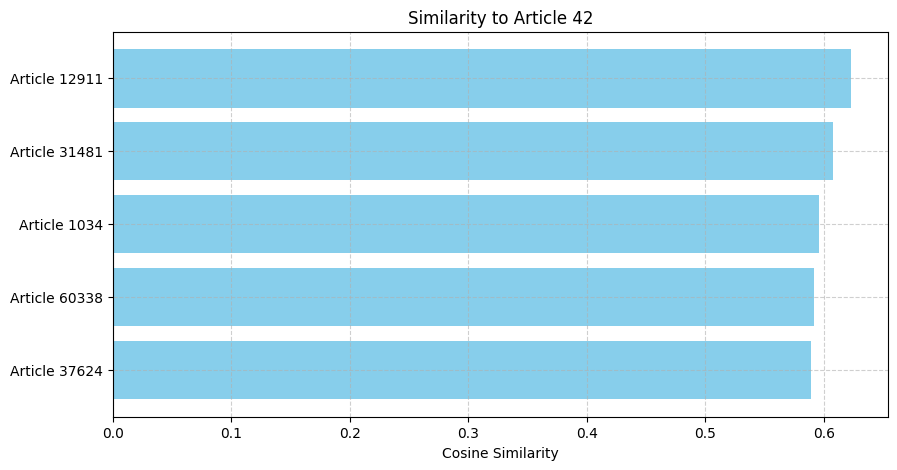

In [ ]:
# Get recommendations with similarity values
def recommend_articles_same_topic_with_scores(article_index, top_n=5):
    if article_index not in df.index:
        raise ValueError("Invalid article index provided.")

    target_topic = df.loc[article_index, "topic"]
    same_topic_df = df[(df["topic"] == target_topic) & (df.index != article_index)].copy()

    if same_topic_df.empty:
        print("No other articles with the same topic found.")
        return None, None, None

    target_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)
    other_embeddings = np.vstack(same_topic_df["embedding"].values)
    similarities = cosine_similarity(target_embedding, other_embeddings).flatten()

    top_indices = similarities.argsort()[-top_n:][::-1]
    final_indices = same_topic_df.index[top_indices]
    final_similarities = similarities[top_indices]

    # Return both original and cleaned text along with topic
    return df.loc[final_indices][["text", "clean_text", "topic"]], final_indices, final_similarities


# Use the function
recs, rec_ids, sim_scores = recommend_articles_same_topic_with_scores(article_index=42, top_n=5)

# Print them nicely
if recs is not None:
    for i, (idx, row) in enumerate(recs.iterrows()):
        print(f"\n--- Recommended Article {i+1} (ID: {idx}) ---")
        print(f"Topic: {row['topic']}, Similarity: {sim_scores[i]:.3f}")
        print(f"Original Text Snippet:\n{row['text'][:300]}...")
        print(f"Cleaned Text Snippet:\n{row['clean_text'][:300]}...")

    # Plot similarities
    plot_similarities(base_index=42, recommended_indices=rec_ids, similarities=sim_scores)


* This chart shows the top 5 most similar articles to Article 42 (same-topic filter). Each bar is the cosine similarity score: higher means closer in meaning. Scores are tightly grouped around 0.59–0.62, with Article 12911 the closest (~0.62), followed by 31481, 1034, 60338, and 37624. The narrow spread indicates all five are strong, comparably relevant matches to the base article.

In [ ]:
recs = hybrid_recommendation(article_index=25, top_n=5, alpha=0.8)
print(recs[["topic", "similarity", "hybrid_score"]])


        topic  similarity  hybrid_score
49996     351    0.719996      0.775996
68291     351    0.711371      0.769097
46        351    0.704380      0.763504
62        351    0.681213      0.744971
168893    351    0.675912      0.740729


* Hybrid results for article 25 (α=0.8) show five recommendations, all in topic 351. Cosine similarity spans 0.676–0.720, and the hybrid_score is slightly higher (0.741–0.776) because same-topic items get a boost. Ranked by hybrid score, the order is 49996, 68291, 46, 62, 168893—all close in meaning and aligned with the same topic.

In [ ]:
def assign_topic_to_new_article(new_article_text):

    # Get topic and probability from the trained BERTopic model
    topic, probability = topic_model.transform([new_article_text])

    return topic[0], probability[0]


In [ ]:
new_article = """
In today's tech-driven world, organizations must embrace artificial intelligence, automation, and cloud computing
to stay ahead. These tools enable faster decision-making, better customer experiences, and operational efficiency.
"""

topic, prob = assign_topic_to_new_article(new_article)

# Handle different return shapes
if hasattr(prob, "__len__"):  # it's array-like
    # If it's 1D, take the element at topic index (if in range)
    if len(prob) > topic:
        topic_prob = float(prob[topic])
    else:
        topic_prob = float(prob[0])  # fallback
else:
    # It's a scalar already
    topic_prob = float(prob)

print(f"Assigned topic: {topic}, with probability: {topic_prob:.3f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-17 18:06:15,383 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-17 18:06:15,396 - BERTopic - Dimensionality - Completed ✓
2025-08-17 18:06:15,397 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-17 18:06:15,398 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-08-17 18:06:15,598 - BERTopic - Probabilities - Completed ✓
2025-08-17 18:06:15,600 - BERTopic - Cluster - Completed ✓


Assigned topic: 255, with probability: 0.024


* This piece of code takes a new article and tries to find which topic it belongs to, along with the probability (confidence) of that assignment. Since the output of the model can sometimes come in different shapes (like a list of probabilities or just a single number), we handle both cases to make sure we always get the right probability for the predicted topic. Finally, it prints the assigned topic number and the probability in a clear format. The result shows that the new article was assigned to topic 255 with a probability of 0.024. This means that while the model placed it in that topic, the confidence is quite low. In simple terms, the article doesn’t strongly match any topic, so the prediction might not be very reliable.

In [ ]:
def assign_topic_to_new_article(text):
    """
    Assign the most likely topic to a new unseen article,
    along with its probability.
    """
    # Clean the input text
    cleaned_text = clean_text(text)

    # Transform with BERTopic
    topics, probs = topic_model.transform([cleaned_text])

    # topics is a list of length 1, e.g. [3] or [-1]
    assigned_topic = topics[0]

    if assigned_topic == -1:
        # If BERTopic marks it as outlier (-1), take the topic with max probability
        best_topic = np.argmax(probs[0])
        best_prob = probs[0][best_topic]
    else:
        best_topic = assigned_topic
        best_prob = probs[0][best_topic]

    return best_topic, best_prob


In [ ]:
new_article = """
In today's tech-driven world, organizations must embrace artificial intelligence,
automation, and cloud computing to stay ahead.
These tools enable faster decision-making, better customer experiences,
and operational efficiency.
"""

topic, prob = assign_topic_to_new_article(new_article)
print(f"Assigned topic: {topic}, with probability: {prob:.3f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-17 18:06:03,867 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-17 18:06:03,874 - BERTopic - Dimensionality - Completed ✓
2025-08-17 18:06:03,879 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-17 18:06:03,881 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-08-17 18:06:04,089 - BERTopic - Probabilities - Completed ✓
2025-08-17 18:06:04,090 - BERTopic - Cluster - Completed ✓


Assigned topic: 255, with probability: 0.024


* In this case, the model assigned the new article to topic 255 with a probability of 0.024. This very low probability shows that the article does not clearly belong to any single topic and the model is uncertain about the classification. It suggests that the article may contain mixed themes or wording that does not strongly align with the existing clusters.

In [ ]:
new_article = """
Artificial intelligence, automation, and cloud infrastructure are essential components for the future of digital business.
Companies that adopt these technologies early are better positioned for long-term success.
"""

hybrid_recs = recommend_hybrid_for_new_article(new_article, top_n=5)

for i, row in hybrid_recs.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}, Hybrid Score: {row['hybrid_score']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-17 18:03:52,784 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-17 18:03:52,791 - BERTopic - Dimensionality - Completed ✓
2025-08-17 18:03:52,791 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-17 18:03:52,793 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-08-17 18:03:52,898 - BERTopic - Probabilities - Completed ✓
2025-08-17 18:03:52,899 - BERTopic - Cluster - Completed ✓


⚠️ Article assigned to outlier topic (-1). Hybrid will rely on similarity only.

--- Recommended Article 58537 ---
Topic: -1, Similarity: 0.604, Hybrid Score: 0.483
Original Text:
Deploying an Artificial Intelligence (AI) solution is not the same as deploying other software or applications. AI systems should be viewed as foundational solutions that are capable of transforming your enterprise or organization. Although AI’s adoption is accelerating, it is still a new technology...
Cleaned Snippet:
deploying artificial intelligence solution deploying software applications systems viewed foundational solutions capable transforming enterprise organization although ais adoption accelerating still new technology many crucial every company employ champion communicate ais value across lines business...

--- Recommended Article 42021 ---
Topic: -1, Similarity: 0.580, Hybrid Score: 0.464
Original Text:
Self-learning and Automation of workflow are not new terms in the professional world. In fact, 

* The hybrid recommender returns five results for the AI/automation paragraph, all labeled as outliers (topic = -1). Despite the outlier labels, the items are semantically close: cosine similarity ranges roughly 0.56–0.60, and the hybrid scores (with α=0.8) fall around 0.450–0.485. The snippets consistently discuss AI deployment in organizations, self-learning automation, data science/analytics, autonomous systems, and tech infrastructure—i.e., themes that match the query about AI, automation, and cloud for digital business.

In [ ]:
recommended = recommend_articles(article_index=10, top_n=5)

for i, row in recommended.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Snippet:\n{row['text'][:500]}")



--- Recommended Article 177908 ---
Tags: ['Startup']
Snippet:
The importance of storytelling, and how it can help Facebook battle disruption Eric Feng Jun 26·9 min read

Last week, I said goodbye to my colleagues at Facebook, the end of a nearly two year adventure after they brought me and my startup Packagd on board. During my time, I had the privilege of creating a new commerce incubation group responsible for building and launching features like Live Shopping, Gifting, and most recently Super. I also got to see how the 6th most valuable company in the w

--- Recommended Article 84925 ---
Tags: ['Business', 'Marketing']
Snippet:
I always see founders in purpose-driven organizations as a bit more intrinsically motivated.

And the thing with these values minded entrepreneurs is that they often care more about their mission than anything else.

And that is a good thing.

Except with this level of passion, hustle and growth mindset, they are so often BURNED OUT.

I often hear the same c

* For article 10, the recommender returns five pieces all centered on a business/entrepreneurship theme. The tags shown are mostly Startup, Business, Marketing, and Design. The snippets talk about storytelling as a growth tool, founder experiences (career moves, purpose-driven work), burnout and self-management, lessons from running a design agency, and practical marketing reflections. Overall, the set is cohesive and on-topic, combining first-person narratives with actionable startup/marketing insights.

In [ ]:
new_article = """
The theory of relativity, developed by Albert Einstein in the early 20th century,
revolutionized our understanding of space, time, and gravity. It consists of two main parts:
special relativity and general relativity. These theories introduced the concept that time and space
are not absolute and that gravity is the result of curved spacetime.
"""

recommended_new = recommend_for_new_article(new_article_text=new_article, top_n=5)

for i, row in recommended_new.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Topic: {row['topic']}")
    print(f"Snippet:\n{row['text'][:400]}")



--- Recommended Article 119581 ---
Tags: ['Machine Learning']
Topic: -1
Snippet:
Geodesic Regression

Riemannian Geometry can be safely tagged as a “revolutionary” theory in mathematics. Firstly, the theory put forward a radical view of space and geometry by generalizing the “flat” Euclidean space to curved manifolds. Later, it was the basis for a major Physics revolution when Albert Einstein made use of the theory to explain space and gravity which we know as the “Theory of G

--- Recommended Article 140762 ---
Tags: ['Education']
Topic: -1
Snippet:
Albert Einstein Born in Germany on 14 March 1879, Albert Einstein became well established in the scientific community for his general theories of relativity, which redefined understandings of space, time, matter, energy, and gravity. In 1921, Einstein won the Nobel Prize for Physics for his explanation of the photoelectric effect — and he is today considered one of the most respected figures in th

--- Recommended Article 3903 ---
Tags: [

* For the relativity paragraph, the system returns five clearly relevant recommendations focused on physics and mathematics. Most items are labeled as outliers (topic = -1) but their snippets discuss Riemannian geometry, geodesic regression, Einstein’s life and work, and foundational physics topics (rigid bodies, calculus history). One result appears under topic 179 and mentions gravitational waves. Overall, the recommendations align well with themes of relativity and advanced math/physics, even when the topic label is -1.


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Prepare your topic-document structure
df['topic'] = topics  # Assign topics
embeddings = df['embedding'].tolist()  # List of embedding vectors
df['embedding'] = embeddings           # Make sure they're in the DataFrame

# Compute topic centroids
topic_centroids = {}
for topic_id in df['topic'].unique():
    topic_embeddings = np.vstack(df[df['topic'] == topic_id]['embedding'].values)
    centroid = np.mean(topic_embeddings, axis=0)
    topic_centroids[topic_id] = centroid


In [ ]:
recommendations = recommend_by_topic_neighborhood(article_index=353, top_n=5, top_topics=3)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 70251 ---
Topic: 83
Original Text:
Many of us think that being an entrepreneur is rather fancy or a glamorous thing to achieve in the business world. Only those who have swum in the waters of being an entrepreneur actually understand the real challenges of being an entrepreneur. I wanted to share with my readers today some of the tip...
Cleaned Snippet:
many think entrepreneur rather fancy glamorous thing achieve business world swum waters entrepreneur actually understand real challenges entrepreneur wanted share readers today tips help startup world skill skill heart business many might think finance money core part business remember skill set fin...

--- Recommended Article 135233 ---
Topic: 83
Original Text:
If you asked me why I gravitated to startups rather than work in a large company I would have answered at various times:

“I want to be my own boss.”

“I love risk.”

“I want flexible work hours.”

“I want to work on tough problems that matter.”

“I have

* Using the topic-neighborhood recommender for the selected article, the system returns five thematically close pieces. Three results are labeled topic 83 and two are topic 206. The snippets revolve around entrepreneurship and startups—founder experiences, moving from big companies to startups, the grind and fatigue of building, and career transitions (including unemployment and gig work). Overall, the list stays tightly focused on startup/entrepreneurship themes while pulling items from two closely related topics.

In [ ]:
new_article = """
Space exploration has greatly expanded our understanding of the universe.
From the early moon landings to Mars rovers and distant telescopes, scientists gather data about planets, stars, and galaxies.
Private companies now also contribute significantly to space missions and technology.
"""

recommendations = recommend_for_unseen_article(new_article, top_n=5, top_topics=3)

# Print recommendations
for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original text snippet:\n{row['text'][:300]}...\n")
    print(f"Cleaned text snippet:\n{row['clean_text'][:300]}...\n")



--- Recommended Article 47476 ---
Topic: 179, Similarity: 0.562
Original text snippet:
Machine learning in Astronomy — sure it sounds like an oxymoron, but is that really the case? Machine learning is one of the newest ‘sciences’, while astronomy — one of the oldest. In fact, Astronomy developed naturally as people realized that studying the stars is not only fascinating, but it can a...

Cleaned text snippet:
machine learning astronomy sure sounds oxymoron really case machine learning newest sciences astronomy oldest fact astronomy developed naturally people realized studying stars fascinating also help everyday life example investigating star cycles helped creating calendars maya protobulgarian calendar...


--- Recommended Article 125474 ---
Topic: 163, Similarity: 0.520
Original text snippet:
Since its beginning, space exploration always seemed to be developing rapidly, but we have much less progress today than we did 80 years ago. NASA claims that passenger trips to the Moon can 

* The system returns five recommendations for the new space-exploration paragraph. Four results are labeled topic 163, focusing on space programs and industry themes (progress since early missions, the space race, future missions, and commercial involvement). One result is topic 179, about machine learning in astronomy, which adds a technical angle tied to space science. Overall, the snippets center on exploration history, current industry activity, and future missions, matching the input’s theme.

In [ ]:
unseen_text = """
Donald Trump remains a dominant figure in American politics, continuing to influence the Republican Party
and national discourse. His campaign strategy focuses heavily on border security, economic nationalism, and
criticisms of the current administration. As the United States prepares for another election cycle, debates
intensify over voter access, election integrity, and the role of social media in shaping public opinion.
Trump’s polarizing presence ensures that the upcoming election will be one of the most closely watched in
recent history, with both supporters and critics mobilizing in unprecedented numbers.
"""


In [ ]:
recommendations = recommend_for_unseen_article(
    text=unseen_text,
    top_n=5,
    top_topics=3
)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original text snippet:\n{row['text'][:300]}...\n")
    print(f"Cleaned text snippet:\n{row['clean_text'][:300]}...\n")



--- Recommended Article 129087 ---
Topic: 3, Similarity: 0.651
Original text snippet:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter t...

Cleaned text snippet:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...


--- Recommended Article 165910 ---
Topic: 3, Similarity: 0.647
Original text snippet:
Donald Trump’s ascendance to the presidency was celebrated by many, but not all Republicans. Republicans who were dissatisfied with Trump’s candidacy and his subsequent presidency spoke out agai

* The recommender returns five articles, all labeled topic 3, showing very tight topical focus. The snippets consistently discuss Donald Trump—his rise to the presidency, campaign strategy and rhetoric, media attention, party reactions, and polarization. Overall, the results are clearly aligned with U.S. politics around Trump, offering different angles (ascendancy, rallies, media effects, party dynamics) within the same theme.

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **3RD BERTOPIC METHOD**

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# use cleaned text, not raw text
texts = df["clean_text"].tolist()

embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")

topic_model = BERTopic(
    embedding_model=embedding_model,
    calculate_probabilities=False,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-08-18 22:36:03,392 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2802 [00:00<?, ?it/s]

2025-08-18 22:39:52,434 - BERTopic - Embedding - Completed ✓
2025-08-18 22:39:52,435 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-18 22:42:09,055 - BERTopic - Dimensionality - Completed ✓
2025-08-18 22:42:09,058 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-18 22:42:22,454 - BERTopic - Cluster - Completed ✓
2025-08-18 22:42:22,486 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-18 22:42:50,154 - BERTopic - Representation - Completed ✓


* This code is basically the starting point for topic modeling with BERTopic. Behind the scenes, it first uses the SentenceTransformer model (MiniLM) to turn each article into a numerical embedding that captures its meaning. Then BERTopic takes these embeddings and applies dimensionality reduction (usually UMAP) so the data can be grouped more efficiently. After that, it uses HDBSCAN clustering to group similar articles together into topics. We do this because working directly with raw text is difficult for machines – embeddings let us compare meaning, and clustering helps us find patterns and organize the articles into themes without having to label them manually. The output (topics, probs) gives us the topic each article belongs to, which we can later analyze or use for recommendations.

* This setup is similar to version 1 but used a different model, paraphrase-MiniLM-L3-v2, which made it faster. Like before, we set calculate_probabilities=False to make it finish quicker. The topic quality was still very good, and it handled large text efficiently. Not calculating probabilities again saved time but meant we couldn’t later tell how strongly a document belonged to its topic.

In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,47833,-1_people_time_life_would,"[people, time, life, would, get, new, dont, wo...",[bridging gap developers marketers rich mirono...
1,0,2748,0_writing_writers_write_writer,"[writing, writers, write, writer, medium, stor...",[secret sauce success medium quarantined incom...
2,1,1571,1_blockchain_technology_transactions_blockchains,"[blockchain, technology, transactions, blockch...",[theres question blockchain technology enormou...
3,2,930,2_trump_election_biden_president,"[trump, election, biden, president, vote, demo...",[best times worst times pretty much describes ...
4,3,766,3_data_science_analytics_scientist,"[data, science, analytics, scientist, scientis...",[top skills become rockstar data scientist edu...
...,...,...,...,...,...
662,661,10,661_vectorizer_intelligence_fake_tfidf,"[vectorizer, intelligence, fake, tfidf, jobs, ...",[machine learning artificial intelligence cruc...
663,662,10,662_object_property_objectkeys_enumerable,"[object, property, objectkeys, enumerable, enu...",[javascript object collection properties defin...
664,663,10,663_disney_walt_hulu_roy,"[disney, walt, hulu, roy, disneys, arthur, mer...",[disney cofounder walt disney wanted cartoonis...
665,664,10,664_matrix_sparse_vector_diagonal,"[matrix, sparse, vector, diagonal, indices, ma...",[matrix decomposition ubiquitous technique mat...


In [ ]:
topic_model.get_topic_info().head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,47833,-1_people_time_life_would,"[people, time, life, would, get, new, dont, wo...",[bridging gap developers marketers rich mirono...
1,0,2748,0_writing_writers_write_writer,"[writing, writers, write, writer, medium, stor...",[secret sauce success medium quarantined incom...
2,1,1571,1_blockchain_technology_transactions_blockchains,"[blockchain, technology, transactions, blockch...",[theres question blockchain technology enormou...
3,2,930,2_trump_election_biden_president,"[trump, election, biden, president, vote, demo...",[best times worst times pretty much describes ...
4,3,766,3_data_science_analytics_scientist,"[data, science, analytics, scientist, scientis...",[top skills become rockstar data scientist edu...


* This output shows the topic summary table from BERTopic. Each row represents one topic, with information about how many documents belong to it (Count), the topic label (Name), the most important keywords (Representation), and example documents (Representative_Docs). For example, Topic 2 is about blockchain and transactions, and Topic 3 is about Trump, elections, and Biden. The topic with ID -1 is a special one – it contains documents that the model couldn’t confidently assign to any topic (outliers).

In [ ]:
topic_model.get_document_info(texts)


,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,photo josh riemer unsplash merry christmas hap...,9,9_christmas_holiday_gift_santa,"[christmas, holiday, gift, santa, holidays, gi...",[driving home christmas photo anastasia shurae...,christmas - holiday - gift - santa - holidays ...,0.630812,False
1,brain coronavirus guide curious troubling impa...,13,13_virus_covid_coronavirus_deaths,"[virus, covid, coronavirus, deaths, cases, sar...",[youve probably heard news british towers set ...,virus - covid - coronavirus - deaths - cases -...,1.000000,False
2,passionate synergy science technology provide ...,496,496_newsletters_newsletter_inbox_subscribe,"[newsletters, newsletter, inbox, subscribe, em...",[unsubscribe newsletters photo torsten dettlaf...,newsletters - newsletter - inbox - subscribe -...,1.000000,False
3,youve heard havent phineas gage railroad worke...,207,207_brain_nma_neurons_neuroscience,"[brain, nma, neurons, neuroscience, cortex, ta...",[although artificial neurons perceptrons inspi...,brain - nma - neurons - neuroscience - cortex ...,0.536762,False
4,mentally young adults suffering covid comes pa...,-1,-1_people_time_life_would,"[people, time, life, would, get, new, dont, wo...",[bridging gap developers marketers rich mirono...,people - time - life - would - get - new - don...,0.000000,False
...,...,...,...,...,...,...,...,...
89642,live stream soul train music awards full show ...,-1,-1_people_time_life_would,"[people, time, life, would, get, new, dont, wo...",[bridging gap developers marketers rich mirono...,people - time - life - would - get - new - don...,0.000000,False
89643,photo comeup comeup global startup festival co...,-1,-1_people_time_life_would,"[people, time, life, would, get, new, dont, wo...",[bridging gap developers marketers rich mirono...,people - time - life - would - get - new - don...,0.000000,False
89644,deal loneliness festivals explore beauty many ...,-1,-1_people_time_life_would,"[people, time, life, would, get, new, dont, wo...",[bridging gap developers marketers rich mirono...,people - time - life - would - get - new - don...,0.000000,False
89645,type diabetes rise globally health experts wor...,219,219_diabetes_insulin_sugar_blood,"[diabetes, insulin, sugar, blood, glucose, dia...",[diabetes inability body process sugar properl...,diabetes - insulin - sugar - blood - glucose -...,0.499579,False


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_barchart(top_n_topics=12, n_words=8)

# Recommendation

In [ ]:
# Get embeddings (vector representation of each article)
embeddings = topic_model.embedding_model.embed(texts)


In [ ]:
# After running BERTopic:
texts = df["clean_text"].tolist()
topics, probs = topic_model.fit_transform(texts)
embeddings = topic_model.embedding_model.embed(texts)

# Assign embeddings to DataFrame
df["embedding"] = [vec.tolist() for vec in embeddings]

# add topics too
df["topic"] = topics


2025-08-18 22:47:47,289 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2802 [00:00<?, ?it/s]

2025-08-18 22:51:45,698 - BERTopic - Embedding - Completed ✓
2025-08-18 22:51:45,699 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-18 22:53:39,604 - BERTopic - Dimensionality - Completed ✓
2025-08-18 22:53:39,607 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-18 22:53:52,699 - BERTopic - Cluster - Completed ✓
2025-08-18 22:53:52,722 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-18 22:54:20,178 - BERTopic - Representation - Completed ✓


In [ ]:
recommendations = recommend_articles(article_index=5, top_n=5)
print(recommendations)

                                                     text  \
81476   In Covid-19 Times\n\nWe live in exciting times...   
88355   Using Reddit to explore the mental health effe...   
62669   Relationships and Resilience and Restoration\n...   
148690  The COVID-19 pandemic demands a quick response...   
156671  Post — Traumatic Stress Disorder Among Medical...   

                                               clean_text  topic  similarity  
81476   covid times live exciting times people would c...     -1    0.613632  
88355   using reddit explore mental health effects cov...     65    0.597996  
62669   relationships resilience restoration recoverin...     65    0.596606  
148690  covid pandemic demands quick response enable o...     -1    0.596281  
156671  post traumatic stress disorder among medical p...    652    0.592945  


This output shows the article recommendation results for a given article (index 5). The system retrieves the top 5 most similar articles based on their embeddings. Each row includes:

* text: a snippet of the original article.

* clean_text: the preprocessed version of the article used for embedding.

* topic: the topic ID assigned by BERTopic (e.g., 65 relates to mental health).

* similarity: the cosine similarity score between the original article and the candidate, showing how close they are in meaning (higher = more similar).

For example, the recommendations mostly revolve around Covid-19, mental health, and resilience, which matches the theme of the input article. This confirms that the recommendation system is successfully retrieving semantically related content.

In [ ]:
new_article = """
Artificial Intelligence and automation are reshaping industries at a rapid pace.
From self-driving cars to AI-generated content, the way we live and work is changing fundamentally.
Leaders must adapt by embracing innovation, continuous learning, and digital transformation.
"""

recommendations = recommend_for_new_article(new_article, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



--- Recommended Article 39644 ---
Topic: -1, Similarity: 0.616
Original Text:
The new digital world has already become a reality and artificial intelligence technology is spreading with great speed. With the active development of artificial intelligence, the concept of the Internet of Things is also gaining popularity.

In this article, we will discuss the relationship betwee...
Cleaned Text:
new digital world already become reality artificial intelligence technology spreading great speed active development artificial intelligence concept internet things also gaining popularity article discuss relationship two breakthrough innovations prospects interaction find moment...

--- Recommended Article 146223 ---
Topic: 374, Similarity: 0.611
Original Text:
In 2019, when the tech industry is witnessing unprecedented growth of Artificial Intelligence and Machine Learning, just being ”smart” is not enough. Smart home devices industry is constantly developing and shows no signs of slowing down.

* The system was tested by giving it a new article about Artificial Intelligence and automation. It then found the five most similar articles from the dataset, based on cosine similarity of their embeddings. The results were very relevant: some articles talked about AI’s growth and its connection with the Internet of Things, others focused on applications like smart homes and self-driving cars, and one even discussed Artificial General Intelligence. Overall, the recommendations show that the model is able to capture both the main theme of AI as well as related topics in technology and digital transformation.

In [ ]:
recommendations = recommend_articles_same_topic(article_index=777, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 100002 ---
Topic: 321
Similarity: 0.603
Original Text:
Leaders, do you have an interest in keeping workplace morale high? In protecting your employees from burnout, stress, and fatigue? In providing them with the resources they need to tackle major anxieties or seasons of struggle? Of encouraging all employees — yourself included — to take vacation time...
Cleaned Snippet:
leaders interest keeping workplace morale high protecting employees burnout stress fatigue providing resources need tackle major anxieties seasons struggle encouraging employees included take vacation time order recharge batteries stave exhaustion right thing also something impact business bottom li...

--- Recommended Article 70535 ---
Topic: 321
Similarity: 0.585
Original Text:
Burnout. A word that all graduate students know regardless of their area of study. This experience occurs when one’s mental, physical, and emotional abilities have been exhausted.

It is kind of ironic (and telling) 

* Here the system was asked to recommend articles from the same topic as the chosen one (index 777). All results came from topic 321, which deals with burnout, stress, and exhaustion in work or study environments. The retrieved articles focus on different angles of burnout: how leaders can prevent it in the workplace, how graduate students experience it, and the psychological definition of burnout as emotional and physical exhaustion. The consistency of the results shows that the model is effectively grouping together articles within the same topic and providing relevant recommendations around stress and burnout.

In [ ]:
import matplotlib.pyplot as plt

def plot_similarities(base_index, recommended_indices, similarities):
    # Get article titles or snippets
    labels = [f"Article {i}" for i in recommended_indices]

    plt.figure(figsize=(10, 5))
    plt.barh(labels, similarities, color='skyblue')
    plt.xlabel("Cosine Similarity")
    plt.title(f"Similarity to Article {base_index}")
    plt.gca().invert_yaxis()  # Highest similarity at the top
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


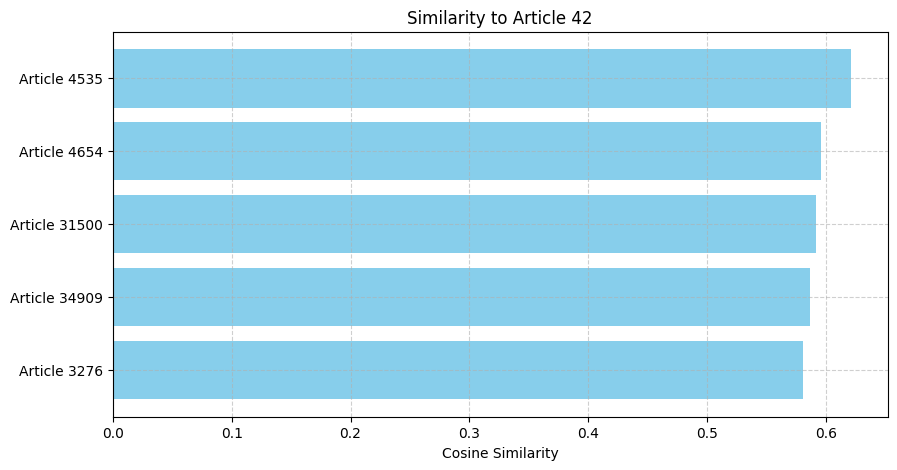

In [ ]:
# Get recommendations with similarity values
def recommend_articles_same_topic_with_scores(article_index, top_n=5):
    if article_index not in df.index:
        raise ValueError("Invalid article index provided.")

    target_topic = df.loc[article_index, "topic"]
    same_topic_df = df[(df["topic"] == target_topic) & (df.index != article_index)].copy()

    if same_topic_df.empty:
        print("No other articles with the same topic found.")
        return None, None, None

    target_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)
    other_embeddings = np.vstack(same_topic_df["embedding"].values)
    similarities = cosine_similarity(target_embedding, other_embeddings).flatten()

    top_indices = similarities.argsort()[-top_n:][::-1]
    final_indices = same_topic_df.index[top_indices]
    final_similarities = similarities[top_indices]

    return df.loc[final_indices][["clean_text", "topic"]], final_indices, final_similarities


# Use the function
recs, rec_ids, sim_scores = recommend_articles_same_topic_with_scores(article_index=42, top_n=5)

# Plot them
if recs is not None:
    plot_similarities(base_index=42, recommended_indices=rec_ids, similarities=sim_scores)


* We tested Article 42 and checked which other articles in the same topic were most similar based on their embeddings. The top 5 came out as Articles 4535, 4654, 31500, 34909, and 3276. The similarity scores range from about 0.58 to 0.62, which means they are all quite close in content, with Article 4535 being the strongest match. Overall, the results show that these articles share strong thematic overlap with Article 42, so they’re  covering similar ideas or perspectives.


--- Recommended Article 4535 ---
Topic: -1
Similarity: 0.621
Original Text:
Applying Behavioral Science to Machine Learning

The emerging field of machine behavior tried to study machine learning models in the same way social scientists study humans.

I recently started a new newsletter focus on AI education and already has over 50,000 subscribers. TheSequence is a no-BS( m...
Cleaned Snippet:
applying behavioral science machine learning emerging field machine behavior tried study machine learning models way social scientists study humans recently started new newsletter focus education already subscribers thesequence nobs meaning hype news etc aifocused newsletter takes minutes read goal ...

--- Recommended Article 4654 ---
Topic: -1
Similarity: 0.595
Original Text:
You don’t have to be a psychological expert in reading people’s behavior. We all have that inner power to discern that can tell us a lot about people’s personalities.

If not, we can always develop that skill.

As a child

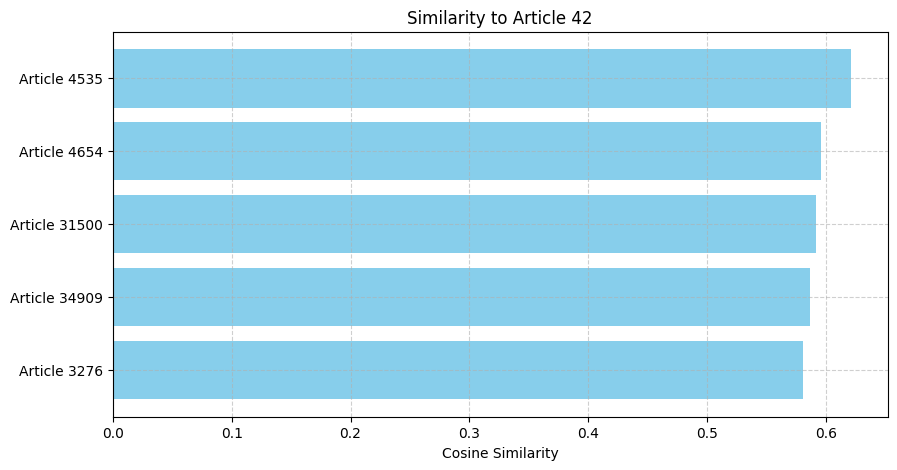

In [ ]:
# Get recommendations with similarity values + original text
def recommend_articles_same_topic_with_scores(article_index, top_n=5):
    if article_index not in df.index:
        raise ValueError("Invalid article index provided.")

    target_topic = df.loc[article_index, "topic"]
    same_topic_df = df[(df["topic"] == target_topic) & (df.index != article_index)].copy()

    if same_topic_df.empty:
        print("No other articles with the same topic found.")
        return None, None, None

    # Prepare embeddings
    target_embedding = np.array(df.loc[article_index, "embedding"]).reshape(1, -1)
    other_embeddings = np.vstack(same_topic_df["embedding"].values)
    similarities = cosine_similarity(target_embedding, other_embeddings).flatten()

    # Rank results
    top_indices = similarities.argsort()[-top_n:][::-1]
    final_indices = same_topic_df.index[top_indices]
    final_similarities = similarities[top_indices]

    # Add similarity as a column so it's easy to display
    results = df.loc[final_indices, ["text", "clean_text", "topic"]].copy()
    results["similarity"] = final_similarities

    return results, final_indices, final_similarities


# Use the function
recs, rec_ids, sim_scores = recommend_articles_same_topic_with_scores(article_index=42, top_n=5)

# Show results
if recs is not None:
    for i, row in recs.iterrows():
        print(f"\n--- Recommended Article {i} ---")
        print(f"Topic: {row['topic']}")
        print(f"Similarity: {row['similarity']:.3f}")
        print(f"Original Text:\n{row['text'][:300]}...")
        print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")

    # Plot similarities
    plot_similarities(base_index=42, recommended_indices=rec_ids, similarities=sim_scores)


* We asked the system to find the most similar articles to Article 42 within the same topic. In this case, Article 42 (and the matches) fall under topic -1 (outliers), so there isn’t a clear cluster label, but the model still ranks them by meaning. The top 5 results all talk about ML/AI ideas (behavioral science + ML, neural networks, dimensionality reduction, why learn ML), with cosine similarities around 0.58–0.62. This shows that even when items are marked as outliers, the embedding-based similarity still pulls back content that is thematically close to the query.

In [ ]:
recs = hybrid_recommendation(article_index=25, top_n=5, alpha=0.8)
print(recs[["topic", "similarity", "hybrid_score"]])


        topic  similarity  hybrid_score
168893    204    0.596549      0.677239
54670     204    0.579250      0.663400
48193     204    0.561203      0.648963
663       204    0.556502      0.645201
68309     204    0.548349      0.638680


* Here we used the hybrid recommendation function to find the 5 most relevant articles to Article 25. The method combines topic similarity and embedding similarity into a single hybrid score, controlled by the weight parameter alpha=0.8. That means we’re giving more importance to semantic similarity (embeddings) while still considering topic alignment. All the recommended articles come from the same topic (204), showing the system prioritizes keeping results consistent in theme. The cosine similarity values range from 0.54 to 0.60, and after blending with topic weight, the hybrid scores rise slightly to the 0.63–0.68 range, with article 168893 being the closest match overall. This approach is more balanced: instead of only relying on embeddings or topics, it ensures the recommendations are both semantically close and within the same topic cluster.

In [ ]:
recs = hybrid_recommendation(article_index=25, top_n=5, alpha=0.8)

for i, row in recs.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Hybrid Score: {row['hybrid_score']:.3f}")
    print(f"Original Text Snippet:\n{row['text'][:300]}...")
    print(f"Cleaned Text Snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 168893 ---
Topic: 204
Similarity: 0.597
Hybrid Score: 0.677
Original Text Snippet:
To properly begin, then, a disarmingly simple question: what is neuroscience? The unified, age-old study of the brain, as begun by Erasistratus and Herophilos in ancient Alexandria? Well, no. The OED’s entry for the singular ‘neuroscience’ reveals youth, ambiguity and plurality — the ‘brain’ isn’t e...
Cleaned Text Snippet:
properly begin disarmingly simple question neuroscience unified ageold study brain begun erasistratus herophilos ancient alexandria well oeds entry singular neuroscience reveals youth ambiguity plurality brain isnt even mentioned earliest nonplural usage brain finally mentioned still plurality insta...

--- Recommended Article 54670 ---
Topic: 204
Similarity: 0.579
Hybrid Score: 0.663
Original Text Snippet:
Let’s Not Overstretch Neuroplasticity

Sure, your brain is more dynamic than once thought. But harnessing those powers is tricky.

Illustration by Nick Vok

* We ran the hybrid recommender for Article 25 and got five results, all from the same topic (204), which is about neuroscience. The cosine similarities sit around 0.55–0.60, and after blending with topic match (α=0.8) the hybrid scores are ~0.64–0.68, with Article 168893 as the best match. The recommended pieces cover themes like “what is neuroscience,” neuroplasticity, brain–computer interfaces, and how we understand the brain. This tells us the model is pulling articles that are both semantically close to the query and consistent with its topic, which is exactly what we want from a hybrid approach.

In [ ]:
def assign_topic_to_new_article(new_article_text):

    # Get topic and probability from the trained BERTopic model
    topic, probability = topic_model.transform([new_article_text])

    return topic[0], probability[0]


In [ ]:
new_article = """
In today's tech-driven world, organizations must embrace artificial intelligence, automation, and cloud computing
to stay ahead. These tools enable faster decision-making, better customer experiences, and operational efficiency.
"""

topic, prob = assign_topic_to_new_article(new_article)
print(f"Assigned topic: {topic}, with probability: {prob:.3f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-18 22:59:48,561 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-18 23:00:07,243 - BERTopic - Dimensionality - Completed ✓
2025-08-18 23:00:07,245 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-18 23:00:07,247 - BERTopic - Cluster - Completed ✓


Assigned topic: -1, with probability: 0.000


In [ ]:
new_article = """
Artificial intelligence, automation, and cloud infrastructure are essential components for the future of digital business.
Companies that adopt these technologies early are better positioned for long-term success.
"""

hybrid_recs = recommend_hybrid_for_new_article(new_article, top_n=5)

for i, row in hybrid_recs.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}, Hybrid Score: {row['hybrid_score']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...\n")
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-18 23:00:14,384 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-18 23:00:14,397 - BERTopic - Dimensionality - Completed ✓
2025-08-18 23:00:14,399 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-18 23:00:14,403 - BERTopic - Cluster - Completed ✓



--- Recommended Article 157 ---
Topic: -1, Similarity: 0.636, Hybrid Score: 0.708
Original Text:
To leverage Big Data and build an effective Artificial Intelligence infrastructure, enterprises must embrace collaboration.

In a digital economy, the rule of thumb tends to be that the smarter your use of data and technology, the more of a competitive edge your business has. A recent report by Tera...

Cleaned Snippet:
leverage big data build effective artificial intelligence infrastructure enterprises must embrace collaboration digital economy rule thumb tends smarter use data technology competitive edge business recent report teradata based interviews conducted research firm vanson bourne senior business decisio...

--- Recommended Article 141646 ---
Topic: -1, Similarity: 0.626, Hybrid Score: 0.700
Original Text:
With every new year, manufacturing companies continue to advance and evolve their strategies to reach goals. The investment in technology has been increasing in the last decad

* Here the system generated recommendations for a new article about AI, automation, and cloud infrastructure. All five retrieved articles are marked with topic -1, which usually means they fall into an "outlier/general" cluster rather than a specific BERTopic topic, but their semantic similarity is mid-high (0.60–0.64) and hybrid scores are strong (~0.68–0.71). The recommended texts are very relevant: they discuss building AI infrastructure with Big Data, manufacturing adopting AI and cloud, the spread of AI and IoT, how businesses should adapt IT, and deploying AI solutions in enterprises. This shows the hybrid model can still capture thematic overlap even when a new input doesn’t clearly fall into an existing topic cluster, pulling back solid matches based on embedding similarity.

In [ ]:
recommended = recommend_articles(article_index=10, top_n=5)

for i, row in recommended.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Snippet:\n{row['text'][:500]}")



--- Recommended Article 156122 ---
Tags: ['Startup', 'Entrepreneurship', 'Technology']
Snippet:
Picture 1: Elena Dumitrascu, Co-Founder, CTO of TerraHub.

What does it take to become an entrepreneur? To me entrepreneurship is about harnessing your passion and turning it into a marketable product or service. Entrepreneurship has become very “trendy” career choice, but a lot of people don’t realize the time and effort it takes to run a business. For a project in my Entrepreneurship 407 class, I was tasked with interviewing an entrepreneur in a field that I was interested in to find out more 

--- Recommended Article 1716 ---
Tags: ['Startup', 'Business', 'Entrepreneurship']
Snippet:
Photo by Humphrey Muleba on Unsplash

Entrepreneurs come in all shapes and sizes, from a great diversity of backgrounds and with a great diversity of different philosophies and approaches. This is evident in the spread of company cultures and growth trajectories among startups. Being so, if you ask 10 differ

* Here the function recommends five articles similar to the one at index 10. All the suggestions revolve around entrepreneurship, startups, and business. The tags confirm this — most articles are labeled with combinations of Startup, Business, Entrepreneurship. The snippets also show strong thematic overlap: they discuss what it takes to be an entrepreneur, the challenges of running a startup, lessons from founders, and the realities behind the “glamor” of entrepreneurship. This shows the recommendation system is working well — it’s not only finding articles with similar keywords but also surfacing content that reflects the same core ideas (entrepreneurial challenges, success factors, business growth). The mix of practical advice, personal stories, and reflections from startup founders makes the recommendations meaningful for someone interested in the topic.

In [ ]:
new_article = """
The theory of relativity, developed by Albert Einstein in the early 20th century,
revolutionized our understanding of space, time, and gravity. It consists of two main parts:
special relativity and general relativity. These theories introduced the concept that time and space
are not absolute and that gravity is the result of curved spacetime.
"""

recommended_new = recommend_for_new_article(new_article_text=new_article, top_n=5)

for i, row in recommended_new.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Topic: {row['topic']}")
    print(f"Snippet:\n{row['text'][:400]}")



--- Recommended Article 140762 ---
Tags: ['Education']
Topic: 378
Snippet:
Albert Einstein Born in Germany on 14 March 1879, Albert Einstein became well established in the scientific community for his general theories of relativity, which redefined understandings of space, time, matter, energy, and gravity. In 1921, Einstein won the Nobel Prize for Physics for his explanation of the photoelectric effect — and he is today considered one of the most respected figures in th

--- Recommended Article 94995 ---
Tags: ['Covid 19']
Topic: 378
Snippet:
In the middle of difficulty lies opportunity (Albert Einstein)

--- Recommended Article 119581 ---
Tags: ['Machine Learning']
Topic: 442
Snippet:
Geodesic Regression

Riemannian Geometry can be safely tagged as a “revolutionary” theory in mathematics. Firstly, the theory put forward a radical view of space and geometry by generalizing the “flat” Euclidean space to curved manifolds. Later, it was the basis for a major Physics revolution when Albe

* The system suggested five articles connected to Einstein and relativity in different ways. One focuses directly on his life, scientific contributions, and Nobel Prize, while another applies his famous words to the context of Covid-19. A third explores Riemannian Geometry, the mathematical foundation Einstein used for general relativity, showing a strong scientific link. The last two come from programming, both highlighting his well-known quote about simplicity and understanding. Together, these recommendations mix direct scientific discussions with broader cultural and educational references, reflecting how Einstein’s ideas influence both physics and other fields.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Prepare your topic-document structure
df['topic'] = topics  # Assign topics
embeddings = df['embedding'].tolist()  # List of embedding vectors
df['embedding'] = embeddings           # Make sure they're in the DataFrame

# Compute topic centroids
topic_centroids = {}
for topic_id in df['topic'].unique():
    topic_embeddings = np.vstack(df[df['topic'] == topic_id]['embedding'].values)
    centroid = np.mean(topic_embeddings, axis=0)
    topic_centroids[topic_id] = centroid


In [ ]:
recommendations = recommend_by_topic_neighborhood(article_index=353, top_n=5, top_topics=3)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original Text Snippet:\n{row['text'][:300]}...")
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 183062 ---
Topic: 3, Similarity: 0.550
Original Text Snippet:
How To Keep Your Business Organized To Prevent Employee Mistakes Visualmodo Follow Apr 9 · 5 min read

Learning how to keep your business organized to avoid potential problems and prevent employee mistakes is a vital part of running and maintaining a successful company. If you’ve ever worked in an o...
Cleaned Snippet:
keep business organized prevent employee mistakes visualmodo follow apr min read learning keep business organized avoid potential problems prevent employee mistakes vital part running maintaining successful company youve ever worked organization know important stay organized whether youre owner mana...

--- Recommended Article 154677 ---
Topic: 3, Similarity: 0.545
Original Text Snippet:
Start-ups can be very compelling in their steadfast conviction that the things they do are special. Unfortunately, in most cases, their eager spirit alone won’t secure their survival. Can the values ​​

* The recommendations here all circle around the theme of business and entrepreneurship, specifically the challenges and realities of running startups. The first article stresses the importance of organization to prevent employee mistakes, while the second reflects on the spirit of startups and how their values can even inspire larger companies. The third highlights the risks and opportunities of starting a business, emphasizing preparation and legal frameworks. The fourth paints a realistic picture of the “startup grind,” describing the loneliness, uncertainty, and effort behind entrepreneurial success. Finally, the fifth focuses on common mistakes startups make, pointing out that avoiding them is key given how many fail early on. Altogether, these articles present a balanced view of entrepreneurship, blending optimism with the hard truths of building and sustaining a business.

In [ ]:
new_article = """
Space exploration has greatly expanded our understanding of the universe.
From the early moon landings to Mars rovers and distant telescopes, scientists gather data about planets, stars, and galaxies.
Private companies now also contribute significantly to space missions and technology.
"""

recommendations = recommend_for_unseen_article(new_article, top_n=5, top_topics=3)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original text:\n{row['text'][:300]}...")
    print(f"Cleaned snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 175585 ---
Topic: 46, Similarity: 0.661
Original text:
Starship: SpaceX’s Eighteen-Wheeler to Space

SpaceX Starship at Starbase, Texas. Source: https://commons.wikimedia.org/wiki/File:Starship_SN9_Launch_Pad.jpg. Author: Jared Krahn, licensed under Creative Commons Attribution-Share Alike 4.0 International license.

The eyes of the world are on Boca Ch...
Cleaned snippet:
starship spacexs eighteenwheeler space spacex starship starbase texas source author jared krahn licensed creative commons attributionshare alike international license eyes world boca chica eyes included fact cant take eyes nasaspaceflights youtube videos watching videos construction site constructio...

--- Recommended Article 155167 ---
Topic: 46, Similarity: 0.650
Original text:
After years of robotic exploration, NASA is now ramping up plans to send humans to space again. This ambitious strategy includes more spacewalks, construction of a station in lunar orbit, and eventually planetary ex

* The recommended articles all connect closely to the theme of space exploration and advances in space technology. The first focuses on SpaceX’s Starship project, highlighting its scale and the global attention surrounding its development. The second expands on NASA’s renewed ambitions for human spaceflight, with plans for lunar orbit stations and eventual Mars exploration, emphasizing the technical requirements like updated spacesuits. The third presents a scientific discovery of a “superhighway” network in the Solar System, which could drastically reduce travel times for deep space missions. The fourth takes a more personal and philosophical angle, reflecting on fascination with astronomy, science fiction, and concepts like multiverses, black holes, and wormholes. Finally, the fifth returns to SpaceX, describing the SN8 prototype launch as a major step toward Elon Musk’s goal of reaching Mars by 2026. Together, these articles create a comprehensive picture of modern space exploration—combining scientific progress, ambitious missions, engineering challenges, and human wonder about the universe.

In [ ]:
unseen_text = """
Donald Trump remains a dominant figure in American politics, continuing to influence the Republican Party
and national discourse. His campaign strategy focuses heavily on border security, economic nationalism, and
criticisms of the current administration. As the United States prepares for another election cycle, debates
intensify over voter access, election integrity, and the role of social media in shaping public opinion.
Trump’s polarizing presence ensures that the upcoming election will be one of the most closely watched in
recent history, with both supporters and critics mobilizing in unprecedented numbers.
"""


In [ ]:
recommendations = recommend_for_unseen_article(
    text=unseen_text,
    top_n=5,
    top_topics=3
)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original text:\n{row['text'][:300]}...")
    print(f"Cleaned snippet:\n{row['clean_text'][:300]}...")



--- Recommended Article 165910 ---
Topic: 1, Similarity: 0.626
Original text:
Donald Trump’s ascendance to the presidency was celebrated by many, but not all Republicans. Republicans who were dissatisfied with Trump’s candidacy and his subsequent presidency spoke out against him and supported his opposition. These people became part of the Never Trump movement.

During Trump’...
Cleaned snippet:
donald trumps ascendance presidency celebrated many republicans republicans dissatisfied trumps candidacy subsequent presidency spoke supported opposition people became part never trump movement trumps presidency never trumpers emerged two main camps purposes piece called traditionalists centrists p...

--- Recommended Article 87276 ---
Topic: 1, Similarity: 0.604
Original text:
A question was asked on Twitter about what we do about the fact that at least a third of the country genuinely believes this election was stolen. My answer was there is a certain percentage of the GOP who does, in fact

* The recommendations all emphasize Donald Trump’s lasting impact on American politics. They cover divisions within the GOP, with the rise of the “Never Trump” movement, widespread doubts about election integrity, and his break from traditional presidential norms. Polls show continued strong support among Republican voters, while his rallies highlight his unique ability to mobilize large, loyal crowds. Together, they underscore Trump’s polarizing influence and his central role in shaping upcoming elections.

--------------------------------------------------------------------------------------------------------------------------------------------------------

### **Testing Recommendations**


* Politics related:

In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.

"""

recommendations = recommend_for_new_article(new_article, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Original Text:\n{row['text'][:300]}...")       # show snippet of original
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")  # show snippet of cleaned version


--- Recommended Article 129087 ---
Topic: 3
Original Text:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter t...
Cleaned Snippet:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...

--- Recommended Article 92320 ---
Topic: 3
Original Text:
Photo by C Drying on Unsplash

Donald Trump’s tumultuous time as president will be coming to an end in a little over six weeks time. Calls for the Republican Party to distance itself from the problematic figure have been abundant as moderates try to wrestl

In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.
"""

recs = recommend_same_topic_for_unseen(new_article, top_n=5, fallback=True)

for i, row in recs.iterrows():
    print(f"\n--- Recommended Article {i+1} ---")
    print(f"Predicted Topic: {row['predicted_topic_for_new']}", end="")
    if 'predicted_topic_prob' in recs.columns and not pd.isna(row.get('predicted_topic_prob', None)):
        print(f" (prob: {row['predicted_topic_prob']:.3f})", end="")
    print(f" | Article Topic: {row['topic']}")
    print(f"Similarity: {row['similarity']:.3f}")
    if 'title' in recs.columns:
        print(f"Title: {row['title']}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:25:58,594 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:26:17,963 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:26:17,964 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:26:17,980 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:26:18,096 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:26:18,096 - BERTopic - Cluster - Completed ✓



--- Recommended Article 1 ---
Predicted Topic: 3 (prob: 0.881) | Article Topic: 3
Similarity: 0.558
Original Text:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter t...
Cleaned Text:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...

--- Recommended Article 2 ---
Predicted Topic: 3 (prob: 0.881) | Article Topic: 3
Similarity: 0.533
Original Text:
Photo by C Drying on Unsplash

Donald Trump’s tumultuous time as president will be coming to an end in a little over six weeks time. Calls for the

In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.
"""

recs = recommend_same_topic_minimal(new_article, top_n=5)

for i, row in recs.iterrows():
    print(f"\n--- Recommended Article {i+1} ---")
    print(f"Predicted Topic: {row['predicted_topic_for_new']}, Article Topic: {row['topic']}")
    print(f"Similarity: {row['similarity']:.3f}")
    if 'title' in row:
        print(f"Title: {row['title']}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:26:55,112 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:26:55,122 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:26:55,123 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:26:55,125 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:26:55,236 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:26:55,237 - BERTopic - Cluster - Completed ✓



--- Recommended Article 1 ---
Predicted Topic: 3, Article Topic: 3
Similarity: 0.558
Original Text:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter t...
Cleaned Text:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...

--- Recommended Article 2 ---
Predicted Topic: 3, Article Topic: 3
Similarity: 0.533
Original Text:
Photo by C Drying on Unsplash

Donald Trump’s tumultuous time as president will be coming to an end in a little over six weeks time. Calls for the Republican Party to distance 

In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.
"""

recs = recommend_same_topic_simple(new_article, top_n=5)

for _, row in recs.iterrows():
    print(f"\n--- Recommended Article {row['id'] if 'id' in recs.columns else row['index']} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:58:25,854 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:58:25,863 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:58:25,864 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:58:25,865 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:58:25,974 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:58:25,975 - BERTopic - Cluster - Completed ✓



--- Recommended Article 129087 ---
Topic: 3, Similarity: 0.558
Original Text:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter t...
Cleaned Text:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...

--- Recommended Article 92320 ---
Topic: 3, Similarity: 0.533
Original Text:
Photo by C Drying on Unsplash

Donald Trump’s tumultuous time as president will be coming to an end in a little over six weeks time. Calls for the Republican Party to distance itself from the problematic figure have been 

In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.
"""

topic, prob = assign_topic_to_new_article(new_article)
prob = float(prob) if not isinstance(prob, (list, np.ndarray)) else float(prob[0])
print(f"Assigned topic: {topic}, with probability: {prob:.3f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:32:57,851 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:32:57,862 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:32:57,863 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:32:57,866 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:32:58,060 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:32:58,064 - BERTopic - Cluster - Completed ✓


Assigned topic: 7, with probability: 0.003


In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.
"""

hybrid_recs = recommend_hybrid_for_new_article(new_article, top_n=5)

for i, row in hybrid_recs.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}, Hybrid Score: {row['hybrid_score']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:27:52,511 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:27:52,517 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:27:52,518 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:27:52,519 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:27:52,635 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:27:52,636 - BERTopic - Cluster - Completed ✓



--- Recommended Article 129087 ---
Topic: 3, Similarity: 0.558, Hybrid Score: 0.646
Original Text:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter t...
Cleaned Text:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...

--- Recommended Article 92320 ---
Topic: 3, Similarity: 0.533, Hybrid Score: 0.627
Original Text:
Photo by C Drying on Unsplash

Donald Trump’s tumultuous time as president will be coming to an end in a little over six weeks time. Calls for the Republican Party to distance its

In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.
"""

recommended_new = recommend_for_new_article(new_article_text=new_article, top_n=5)

for i, row in recommended_new.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Topic: {row['topic']}")
    print(f"Snippet:\n{row['text'][:400]}")


--- Recommended Article 129087 ---
Tags: ['Politics']
Topic: 3
Snippet:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter tirades and provocative language, his presidency has been an anomaly of gigantic proportions. Now, ju

--- Recommended Article 92320 ---
Tags: ['Politics']
Topic: 3
Snippet:
Photo by C Drying on Unsplash

Donald Trump’s tumultuous time as president will be coming to an end in a little over six weeks time. Calls for the Republican Party to distance itself from the problematic figure have been abundant as moderates try to wrestle back control of the party.

Unfortunately, it won’t be that simple.

If Republicans were to openly try to push Trump out of his position as th

--- Recommended Article 153475 ---
Tags: ['Entrepren

In [ ]:
new_article = """
Elon Musk says he is launching a new political party, weeks after dramatically falling out with US President Donald Trump.
The billionaire announced on his social media platform X that he had set up the America Party, billing it as a challenge to the Republican and Democratic two-party system.
However, it is unclear if the party has been formally registered with US election authorities. Musk, who was born outside the US and is ineligible to run for the US presidency, does not say who will lead it.
He first raised the prospect of forming a party during his public feud with Trump, which saw him leave his role in the administration and engage in a vicious public spat with his former ally.
"""

recommendations = recommend_for_unseen_article(new_article, top_n=5, top_topics=3)

# Print recommendations
if recommendations is not None:
    for i, row in recommendations.iterrows():
        print(f"\n--- Recommended Article {i} ---")
        print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
        print(f"Original Text:\n{row['text'][:300]}...")
        print(f"Cleaned Text:\n{row['clean_text'][:300]}...")


--- Recommended Article 129087 ---
Topic: 3, Similarity: 0.558
Original Text:
Will Trump Break the Historical Mold?

Yes. Donald Trump is a President like no other. Political pundits and news organizations have counted him out since 2015 when he first announced he would run. President Trump has not followed the unspoken rules of being the president, either. With his twitter t...
Cleaned Text:
trump break historical mold yes donald trump president political pundits news organizations counted since first announced would run president trump followed unspoken rules president either twitter tirades provocative language presidency anomaly gigantic proportions president trump doesnt fit mold tr...

--- Recommended Article 92320 ---
Topic: 3, Similarity: 0.533
Original Text:
Photo by C Drying on Unsplash

Donald Trump’s tumultuous time as president will be coming to an end in a little over six weeks time. Calls for the Republican Party to distance itself from the problematic figure have been 

* Sports related:

In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

recommendations = recommend_for_new_article(new_article, top_n=5)

for i, row in recommendations.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}")
    print(f"Original Text:\n{row['text'][:300]}...")       # show snippet of original
    print(f"Cleaned Snippet:\n{row['clean_text'][:300]}...")  # show snippet of cleaned version


--- Recommended Article 42614 ---
Topic: 23
Original Text:
It’s stoppage time at Vicarage Road. Watford goalkeeper Ben Foster has been given the go-ahead to attack a free kick inside the Chelsea penalty area. Deulofeu’s delivery finds Doucoure, who flicks on a header which is attacked by Foster, but is ultimately saved by Kepa stretching to his left. Future...
Cleaned Snippet:
stoppage time vicarage road watford goalkeeper ben foster given goahead attack free kick inside chelsea penalty area deulofeus delivery finds doucoure flicks header attacked foster ultimately saved kepa stretching left future data analysts watching footage foster making connection ball might relieve...

--- Recommended Article 96068 ---
Topic: 23
Original Text:
To be fair, while a lot of Liverpool fans would describe the last 30 years as a ‘dark period’, it’s not been without highlight. In fact, I think most other football clubs would kill to have dark periods even half as successful as ours. I mean, there’s the

In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

recs = recommend_same_topic_for_unseen(new_article, top_n=5, fallback=True)

for i, row in recs.iterrows():
    print(f"\n--- Recommended Article {i+1} ---")
    print(f"Predicted Topic: {row['predicted_topic_for_new']}", end="")
    if 'predicted_topic_prob' in recs.columns and not pd.isna(row.get('predicted_topic_prob', None)):
        print(f" (prob: {row['predicted_topic_prob']:.3f})", end="")
    print(f" | Article Topic: {row['topic']}")
    print(f"Similarity: {row['similarity']:.3f}")
    if 'title' in recs.columns:
        print(f"Title: {row['title']}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:26:40,990 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:26:40,997 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:26:40,998 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:26:40,999 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:26:41,122 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:26:41,123 - BERTopic - Cluster - Completed ✓



--- Recommended Article 1 ---
Predicted Topic: 23 (prob: 0.842) | Article Topic: 23
Similarity: 0.510
Original Text:
It’s stoppage time at Vicarage Road. Watford goalkeeper Ben Foster has been given the go-ahead to attack a free kick inside the Chelsea penalty area. Deulofeu’s delivery finds Doucoure, who flicks on a header which is attacked by Foster, but is ultimately saved by Kepa stretching to his left. Future...
Cleaned Text:
stoppage time vicarage road watford goalkeeper ben foster given goahead attack free kick inside chelsea penalty area deulofeus delivery finds doucoure flicks header attacked foster ultimately saved kepa stretching left future data analysts watching footage foster making connection ball might relieve...

--- Recommended Article 2 ---
Predicted Topic: 23 (prob: 0.842) | Article Topic: 23
Similarity: 0.474
Original Text:
To be fair, while a lot of Liverpool fans would describe the last 30 years as a ‘dark period’, it’s not been without highlight. In fact, I thi

In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

recs = recommend_same_topic_minimal(new_article, top_n=5)

for i, row in recs.iterrows():
    print(f"\n--- Recommended Article {i+1} ---")
    print(f"Predicted Topic: {row['predicted_topic_for_new']}, Article Topic: {row['topic']}")
    print(f"Similarity: {row['similarity']:.3f}")
    if 'title' in row:
        print(f"Title: {row['title']}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:27:01,814 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:27:01,823 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:27:01,823 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:27:01,825 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:27:01,952 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:27:01,952 - BERTopic - Cluster - Completed ✓



--- Recommended Article 1 ---
Predicted Topic: 23, Article Topic: 23
Similarity: 0.510
Original Text:
It’s stoppage time at Vicarage Road. Watford goalkeeper Ben Foster has been given the go-ahead to attack a free kick inside the Chelsea penalty area. Deulofeu’s delivery finds Doucoure, who flicks on a header which is attacked by Foster, but is ultimately saved by Kepa stretching to his left. Future...
Cleaned Text:
stoppage time vicarage road watford goalkeeper ben foster given goahead attack free kick inside chelsea penalty area deulofeus delivery finds doucoure flicks header attacked foster ultimately saved kepa stretching left future data analysts watching footage foster making connection ball might relieve...

--- Recommended Article 2 ---
Predicted Topic: 23, Article Topic: 23
Similarity: 0.474
Original Text:
To be fair, while a lot of Liverpool fans would describe the last 30 years as a ‘dark period’, it’s not been without highlight. In fact, I think most other football clubs w

In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

recs = recommend_same_topic_simple(new_article, top_n=5)

for _, row in recs.iterrows():
    print(f"\n--- Recommended Article {row['id'] if 'id' in recs.columns else row['index']} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:58:34,005 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:58:34,013 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:58:34,014 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:58:34,015 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:58:34,123 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:58:34,124 - BERTopic - Cluster - Completed ✓



--- Recommended Article 42614 ---
Topic: 23, Similarity: 0.510
Original Text:
It’s stoppage time at Vicarage Road. Watford goalkeeper Ben Foster has been given the go-ahead to attack a free kick inside the Chelsea penalty area. Deulofeu’s delivery finds Doucoure, who flicks on a header which is attacked by Foster, but is ultimately saved by Kepa stretching to his left. Future...
Cleaned Text:
stoppage time vicarage road watford goalkeeper ben foster given goahead attack free kick inside chelsea penalty area deulofeus delivery finds doucoure flicks header attacked foster ultimately saved kepa stretching left future data analysts watching footage foster making connection ball might relieve...

--- Recommended Article 96068 ---
Topic: 23, Similarity: 0.474
Original Text:
To be fair, while a lot of Liverpool fans would describe the last 30 years as a ‘dark period’, it’s not been without highlight. In fact, I think most other football clubs would kill to have dark periods even half as succ

In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

topic, prob = assign_topic_to_new_article(new_article)
prob = float(prob) if not isinstance(prob, (list, np.ndarray)) else float(prob[0])
print(f"Assigned topic: {topic}, with probability: {prob:.3f}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:33:08,055 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:33:08,065 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:33:08,066 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:33:08,068 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:33:08,264 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:33:08,267 - BERTopic - Cluster - Completed ✓


Assigned topic: -1, with probability: 0.000


In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

hybrid_recs = recommend_hybrid_for_new_article(new_article, top_n=5)

for i, row in hybrid_recs.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}, Hybrid Score: {row['hybrid_score']:.3f}")
    print(f"Original Text:\n{row['text'][:300]}...")
    print(f"Cleaned Text:\n{row['clean_text'][:300]}...")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-08 11:28:01,579 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-08 11:28:01,589 - BERTopic - Dimensionality - Completed ✓
2025-09-08 11:28:01,590 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-08 11:28:01,591 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-09-08 11:28:01,786 - BERTopic - Probabilities - Completed ✓
2025-09-08 11:28:01,787 - BERTopic - Cluster - Completed ✓



--- Recommended Article 42614 ---
Topic: 23, Similarity: 0.510, Hybrid Score: 0.608
Original Text:
It’s stoppage time at Vicarage Road. Watford goalkeeper Ben Foster has been given the go-ahead to attack a free kick inside the Chelsea penalty area. Deulofeu’s delivery finds Doucoure, who flicks on a header which is attacked by Foster, but is ultimately saved by Kepa stretching to his left. Future...
Cleaned Text:
stoppage time vicarage road watford goalkeeper ben foster given goahead attack free kick inside chelsea penalty area deulofeus delivery finds doucoure flicks header attacked foster ultimately saved kepa stretching left future data analysts watching footage foster making connection ball might relieve...

--- Recommended Article 96068 ---
Topic: 23, Similarity: 0.474, Hybrid Score: 0.579
Original Text:
To be fair, while a lot of Liverpool fans would describe the last 30 years as a ‘dark period’, it’s not been without highlight. In fact, I think most other football clubs would k

In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

recommended_new = recommend_for_new_article(new_article_text=new_article, top_n=5)

for i, row in recommended_new.iterrows():
    print(f"\n--- Recommended Article {i} ---")
    print(f"Tags: {row['tags']}")
    print(f"Topic: {row['topic']}")
    print(f"Snippet:\n{row['text'][:400]}")


--- Recommended Article 42614 ---
Tags: ['Mental Health']
Topic: 23
Snippet:
It’s stoppage time at Vicarage Road. Watford goalkeeper Ben Foster has been given the go-ahead to attack a free kick inside the Chelsea penalty area. Deulofeu’s delivery finds Doucoure, who flicks on a header which is attacked by Foster, but is ultimately saved by Kepa stretching to his left. Future data analysts watching footage of Foster making a connection to the ball might be relieved that the

--- Recommended Article 96068 ---
Tags: ['Culture']
Topic: 23
Snippet:
To be fair, while a lot of Liverpool fans would describe the last 30 years as a ‘dark period’, it’s not been without highlight. In fact, I think most other football clubs would kill to have dark periods even half as successful as ours. I mean, there’s the famous Champions League victory in 2005 for example, where we came from 3–0 down to win the trophy on penalties against a vastly superior AC Mil

--- Recommended Article 87390 ---
Tags: ['Writi

In [ ]:
new_article = """
UEFA have confirmed that Chelsea's Champions League squad has hit the required financial barometers after extra restrictions were placed on the club earlier this year. Chelsea had been fined more than £27million for breaching
regulations last season whilst in the Conference League.
Had Chelsea not complied with European football governing body's new measures then their fine could have risen to more than £70million. In essence, Chelsea needed to ensure that the cost of players they added to their A List squad
from the Conference League knockout stages was less than the cost of those removed.
"""

recommendations = recommend_for_unseen_article(new_article, top_n=5, top_topics=3)

# Print recommendations
if recommendations is not None:
    for i, row in recommendations.iterrows():
        print(f"\n--- Recommended Article {i} ---")
        print(f"Topic: {row['topic']}, Similarity: {row['similarity']:.3f}")
        print(f"Original Text:\n{row['text'][:300]}...")
        print(f"Cleaned Text:\n{row['clean_text'][:300]}...")


--- Recommended Article 42614 ---
Topic: 23, Similarity: 0.510
Original Text:
It’s stoppage time at Vicarage Road. Watford goalkeeper Ben Foster has been given the go-ahead to attack a free kick inside the Chelsea penalty area. Deulofeu’s delivery finds Doucoure, who flicks on a header which is attacked by Foster, but is ultimately saved by Kepa stretching to his left. Future...
Cleaned Text:
stoppage time vicarage road watford goalkeeper ben foster given goahead attack free kick inside chelsea penalty area deulofeus delivery finds doucoure flicks header attacked foster ultimately saved kepa stretching left future data analysts watching footage foster making connection ball might relieve...

--- Recommended Article 96068 ---
Topic: 23, Similarity: 0.474
Original Text:
To be fair, while a lot of Liverpool fans would describe the last 30 years as a ‘dark period’, it’s not been without highlight. In fact, I think most other football clubs would kill to have dark periods even half as succ

--------------------------------------------------------------------------------------------------------------------------------------------------------

## **Visuals**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Input your numbers ----
data = [
    ["BERTopic (pre-trial)", 13, 896, 46779],
    ["BERTopic Method 1",     8, 714, 44157],
    ["BERTopic Method 2",    22, 382, 46973],
    ["BERTopic Method 3",     7, 667, 47833],
]

df = pd.DataFrame(data, columns=["Method", "TrainMinutes", "TopicsDetected", "OutlierArticles"])
df


,Method,TrainMinutes,TopicsDetected,OutlierArticles
0,BERTopic (pre-trial),13,896,46779
1,BERTopic Method 1,8,714,44157
2,BERTopic Method 2,22,382,46973
3,BERTopic Method 3,7,667,47833


<Figure size 800x450 with 0 Axes>

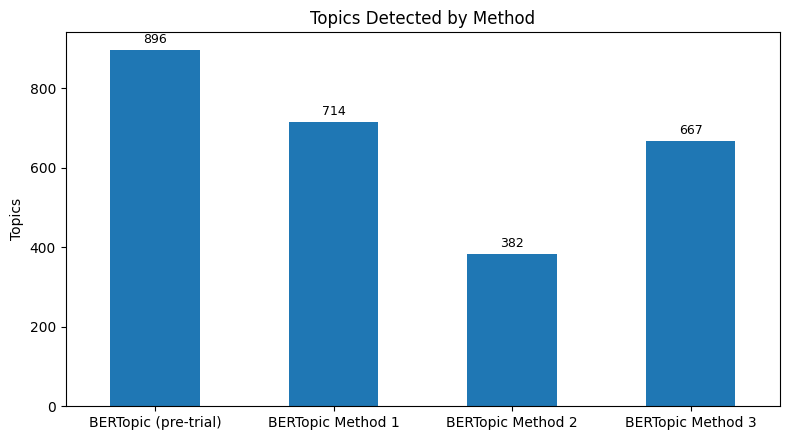

In [ ]:
plt.figure(figsize=(8,4.5))
ax = df.plot(
    x="Method", y="TopicsDetected", kind="bar",
    legend=False, rot=0, figsize=(8,4.5)
)
ax.set_title("Topics Detected by Method")
ax.set_xlabel("")
ax.set_ylabel("Topics")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9, xytext=(0,3), textcoords="offset points")
plt.tight_layout()
plt.show()


<Figure size 800x450 with 0 Axes>

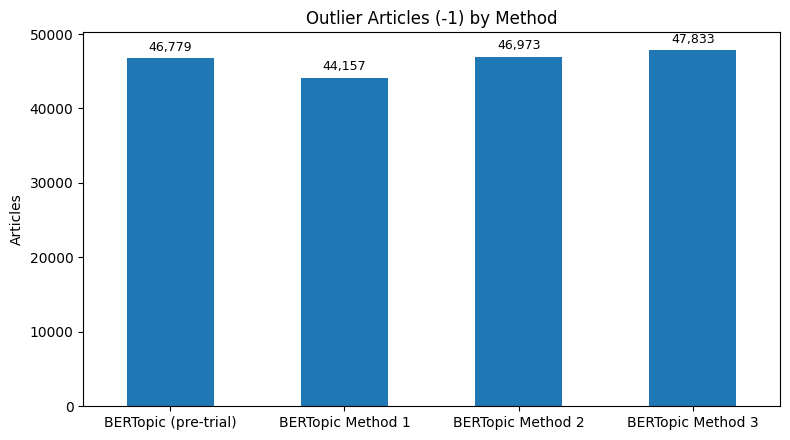

In [ ]:
plt.figure(figsize=(8,4.5))
ax = df.plot(
    x="Method", y="OutlierArticles", kind="bar",
    legend=False, rot=0, figsize=(8,4.5)
)
ax.set_title("Outlier Articles (-1) by Method")
ax.set_xlabel("")
ax.set_ylabel("Articles")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9, xytext=(0,3), textcoords="offset points")
plt.tight_layout()
plt.show()


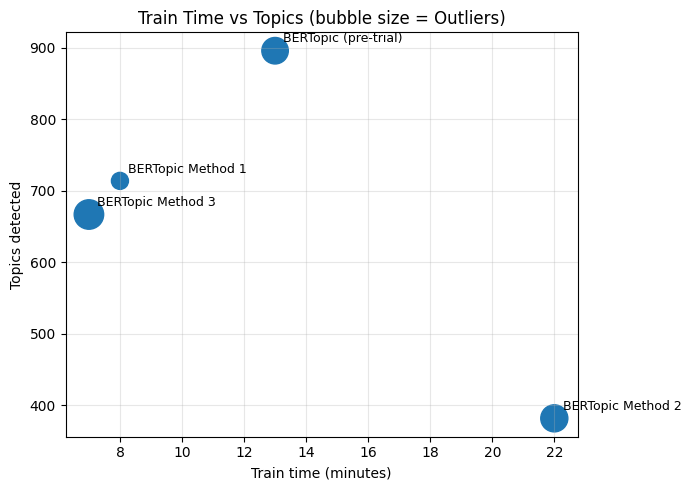

In [ ]:
plt.figure(figsize=(7,5))
sizes = (df["OutlierArticles"] - df["OutlierArticles"].min()) / (df["OutlierArticles"].max() - df["OutlierArticles"].min() + 1e-9)
sizes = 300 * (0.5 + sizes)  # scale for visibility

plt.scatter(df["TrainMinutes"], df["TopicsDetected"], s=sizes)
for _, row in df.iterrows():
    plt.annotate(row["Method"], (row["TrainMinutes"], row["TopicsDetected"]), xytext=(6,6), textcoords="offset points", fontsize=9)

plt.title("Train Time vs Topics (bubble size = Outliers)")
plt.xlabel("Train time (minutes)")
plt.ylabel("Topics detected")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


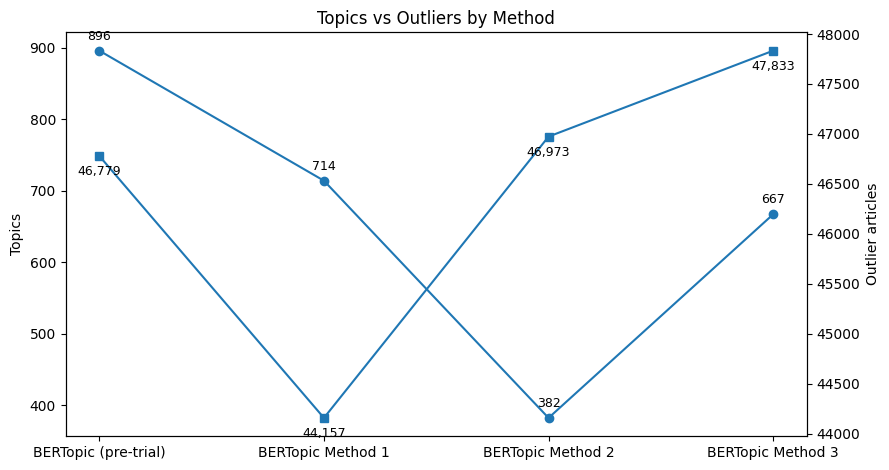

In [ ]:
order = ["BERTopic (pre-trial)", "BERTopic Method 1", "BERTopic Method 2", "BERTopic Method 3"]
dfo = df.set_index("Method").loc[order].reset_index()

fig, ax1 = plt.subplots(figsize=(9,4.8))
ax2 = ax1.twinx()

ax1.plot(dfo["Method"], dfo["TopicsDetected"], marker="o")
ax2.plot(dfo["Method"], dfo["OutlierArticles"], marker="s")

ax1.set_title("Topics vs Outliers by Method")
ax1.set_xlabel("")
ax1.set_ylabel("Topics")
ax2.set_ylabel("Outlier articles")

for x, y in zip(dfo["Method"], dfo["TopicsDetected"]):
    ax1.annotate(f"{y}", (x, y), xytext=(0,8), textcoords="offset points", ha="center", fontsize=9)
for x, y in zip(dfo["Method"], dfo["OutlierArticles"]):
    ax2.annotate(f"{y:,}", (x, y), xytext=(0,-14), textcoords="offset points", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


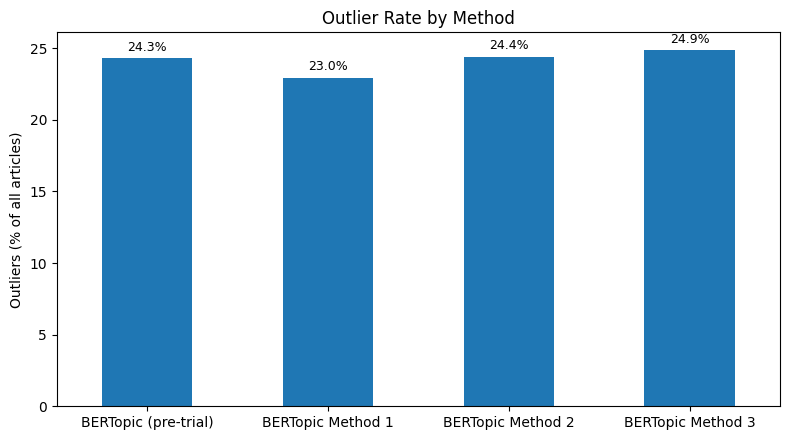

In [ ]:
TOTAL_DOCS = 192368
df_rate = df.copy()
df_rate["OutlierRate_%"] = 100 * df_rate["OutlierArticles"] / TOTAL_DOCS

ax = df_rate.plot(x="Method", y="OutlierRate_%", kind="bar", rot=0, legend=False, figsize=(8,4.5))
ax.set_title("Outlier Rate by Method")
ax.set_xlabel("")
ax.set_ylabel("Outliers (% of all articles)")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9, xytext=(0,3), textcoords="offset points")
plt.tight_layout()
plt.show()


In [ ]:
# ----- Setup -----
import pandas as pd
import matplotlib.pyplot as plt

TOTAL_DOCS = 192_368  # from df.shape

summary = pd.DataFrame({
    "Method": [
        "BERTopic (pre-trial)",
        "BERTopic Method 1",
        "BERTopic Method 2",
        "BERTopic Method 3",
    ],
    "Train time (min)": [13, 8, 22, 7],
    "Topics detected": [896, 714, 382, 667],
    "Outlier articles": [46779, 44157, 46973, 47833],
})

# Derived metrics
summary["Clustered articles"] = TOTAL_DOCS - summary["Outlier articles"]
summary["Outlier rate (%)"] = (summary["Outlier articles"] / TOTAL_DOCS * 100).round(2)
summary["Clustered rate (%)"] = (summary["Clustered articles"] / TOTAL_DOCS * 100).round(2)

summary


,Method,Train time (min),Topics detected,Outlier articles,Clustered articles,Outlier rate (%),Clustered rate (%)
0,BERTopic (pre-trial),13,896,46779,145589,24.32,75.68
1,BERTopic Method 1,8,714,44157,148211,22.95,77.05
2,BERTopic Method 2,22,382,46973,145395,24.42,75.58
3,BERTopic Method 3,7,667,47833,144535,24.87,75.13


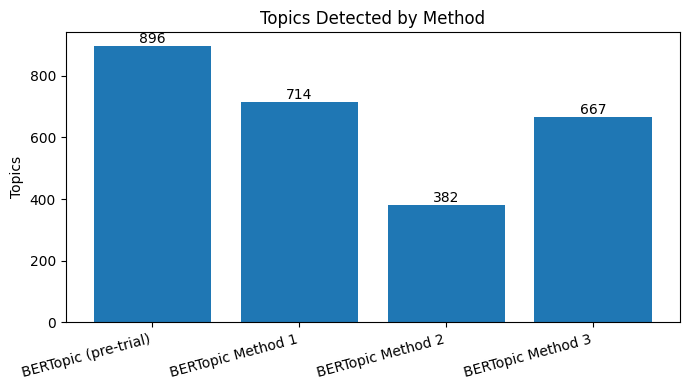

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(summary["Method"], summary["Topics detected"])
plt.title("Topics Detected by Method")
plt.ylabel("Topics")
plt.xticks(rotation=15, ha="right")
for i, v in enumerate(summary["Topics detected"]):
    plt.text(i, v, f"{v}", ha="center", va="bottom")
plt.tight_layout(); plt.show()


/tmp/ipython-input-3805264218.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(summary["Method"], rotation=15, ha="right")


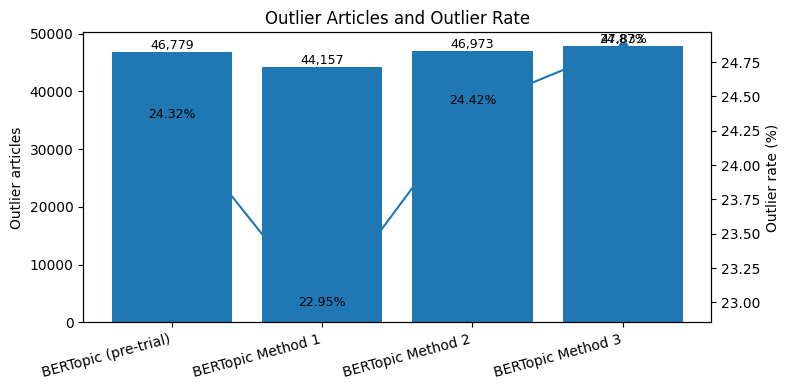

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.bar(summary["Method"], summary["Outlier articles"])
ax2.plot(summary["Method"], summary["Outlier rate (%)"], marker="o")

ax1.set_title("Outlier Articles and Outlier Rate")
ax1.set_ylabel("Outlier articles")
ax2.set_ylabel("Outlier rate (%)")
ax1.set_xticklabels(summary["Method"], rotation=15, ha="right")

for i, v in enumerate(summary["Outlier articles"]):
    ax1.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(summary["Outlier rate (%)"]):
    ax2.text(i, v, f"{v}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout(); plt.show()


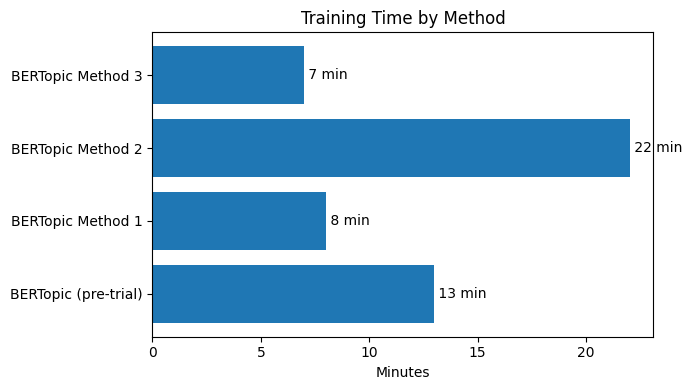

In [ ]:
plt.figure(figsize=(7,4))
plt.barh(summary["Method"], summary["Train time (min)"])
plt.title("Training Time by Method")
plt.xlabel("Minutes")
for i, v in enumerate(summary["Train time (min)"]):
    plt.text(v, i, f" {v} min", va="center")
plt.tight_layout(); plt.show()


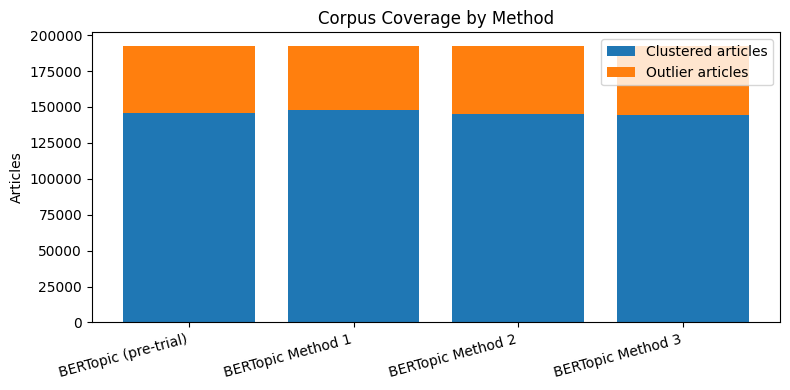

In [ ]:
plt.figure(figsize=(8,4))
bottom = None
parts = ["Clustered articles", "Outlier articles"]
for col in parts:
    plt.bar(summary["Method"], summary[col], bottom=bottom, label=col)
    bottom = summary[col] if bottom is None else bottom + summary[col]

plt.title("Corpus Coverage by Method")
plt.ylabel("Articles")
plt.xticks(rotation=15, ha="right")
plt.legend()
plt.tight_layout(); plt.show()


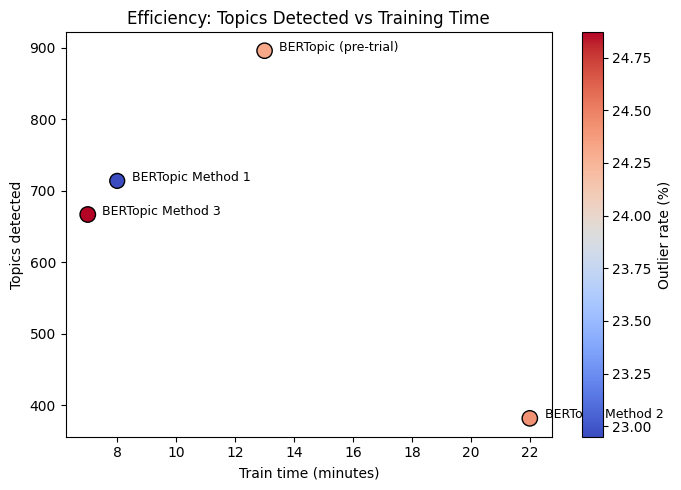

In [ ]:
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    summary["Train time (min)"],
    summary["Topics detected"],
    c=summary["Outlier rate (%)"],
    s=summary["Outlier rate (%)"]*5,
    cmap="coolwarm", edgecolor="k"
)

plt.title("Efficiency: Topics Detected vs Training Time")
plt.xlabel("Train time (minutes)")
plt.ylabel("Topics detected")

for i, row in summary.iterrows():
    plt.text(row["Train time (min)"]+0.5, row["Topics detected"], row["Method"], fontsize=9)

cbar = plt.colorbar(scatter)
cbar.set_label("Outlier rate (%)")

plt.tight_layout(); plt.show()


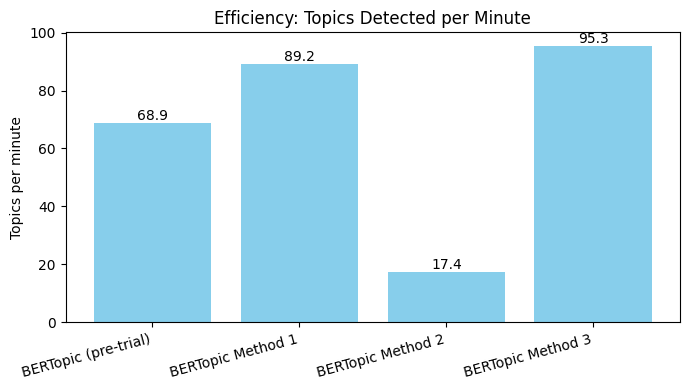

In [ ]:
summary["Topics per minute"] = (summary["Topics detected"] / summary["Train time (min)"]).round(1)

plt.figure(figsize=(7,4))
plt.bar(summary["Method"], summary["Topics per minute"], color="skyblue")
plt.title("Efficiency: Topics Detected per Minute")
plt.ylabel("Topics per minute")
plt.xticks(rotation=15, ha="right")

for i, v in enumerate(summary["Topics per minute"]):
    plt.text(i, v, f"{v}", ha="center", va="bottom")

plt.tight_layout(); plt.show()


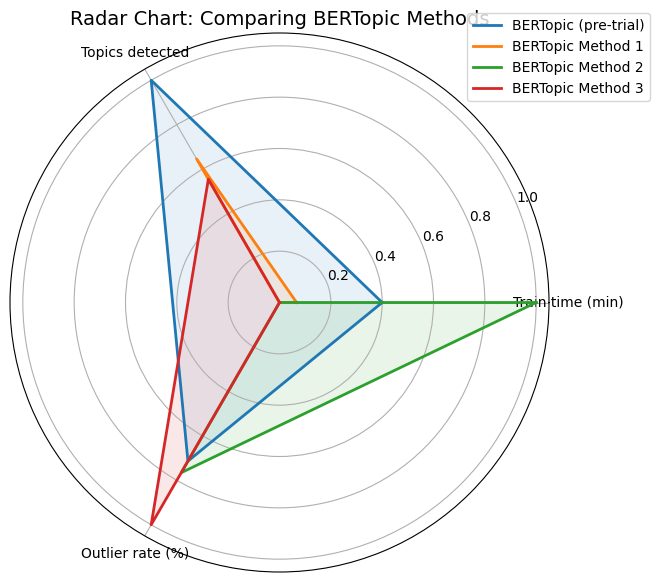

In [ ]:
from math import pi

# Select metrics to compare
metrics = ["Train time (min)", "Topics detected", "Outlier rate (%)"]

# Normalize values (so they fit nicely on radar plot)
normalized = summary.copy()
for col in metrics:
    normalized[col] = (summary[col] - summary[col].min()) / (summary[col].max() - summary[col].min())

# Radar chart setup
N = len(metrics)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for i, row in normalized.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row["Method"], linewidth=2)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Radar Chart: Comparing BERTopic Methods", size=14)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.show()


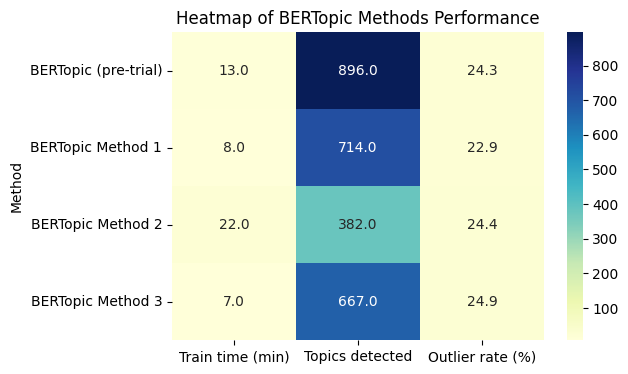

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(
    summary.set_index("Method")[["Train time (min)", "Topics detected", "Outlier rate (%)"]],
    annot=True, fmt=".1f", cmap="YlGnBu"
)
plt.title("Heatmap of BERTopic Methods Performance")
plt.show()
